# Exploration SOFIFA teans stats

## 0. Env variables and connection to db


### 0.1. Importing libraries


In [15]:
import os

import pandas as pd
import numpy as np
from dotenv import load_dotenv

from psycopg2 import sql, connect
from sqlalchemy import create_engine, text

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from train_test.general import train_test_bookies_comparison, display_train_test_bookies_comparison, train_test
from train_test.split import train_test_split_expanding_windows, train_test_split_sliding_windows
from feature_eng.odds import bookie_prediction, prob_by_bookies
from train_test.metrics import accuracy_fn, classwise_ECE_fn, f_mesure_fn, log_loss_fn, mse_loss_fn, precision_fn, recall_fn
from feature_eng.team_stats import goal_stats, elo_scores, glicko2_scores, trueskill_scores


### 0.2 Load env

In [16]:
load_dotenv()
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = os.getenv('DB_NAME')

DB_TN_FBREF_RESULTS = os.getenv('DB_TN_FBREF_RESULTS')
DB_TN_SOFIFA_TEAMS_STATS = os.getenv('DB_TN_SOFIFA_TEAMS_STATS')

### 0.3. Connection to db

In [17]:
connection_url = f'postgresql+psycopg2://{(DB_USER)}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(connection_url)

with engine.connect() as connection:
    query = text(f"SELECT * FROM {DB_TN_FBREF_RESULTS}")
    fbref_results_df = pd.read_sql(query, connection)
    sofifa_teams_stats_df = pd.read_sql(f'SELECT * FROM {DB_TN_SOFIFA_TEAMS_STATS}', connection)

In [4]:
fbref_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87040 entries, 0 to 87039
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   game_id       87004 non-null  object 
 1   league        87040 non-null  object 
 2   season        87040 non-null  object 
 3   game          87040 non-null  object 
 4   round         6898 non-null   object 
 5   week          86321 non-null  float64
 6   day           87040 non-null  object 
 7   date          87040 non-null  object 
 8   time          19340 non-null  object 
 9   home_team     87040 non-null  object 
 10  home_xg       12761 non-null  float64
 11  score         86903 non-null  object 
 12  away_xg       12761 non-null  float64
 13  away_team     87040 non-null  object 
 14  attendance    25155 non-null  float64
 15  venue         44812 non-null  object 
 16  referee       61122 non-null  object 
 17  match_report  87004 non-null  object 
 18  notes         242 non-null

In [5]:
sofifa_teams_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106500 entries, 0 to 106499
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   league                       106500 non-null  object        
 1   team                         106500 non-null  object        
 2   overall                      106500 non-null  int64         
 3   attack                       106500 non-null  int64         
 4   midfield                     106500 non-null  int64         
 5   defence                      106500 non-null  int64         
 6   transfer_budget              106500 non-null  int64         
 7   club_worth                   106500 non-null  float64       
 8   build_up_speed               106500 non-null  object        
 9   build_up_dribbling           106500 non-null  object        
 10  build_up_passing             106500 non-null  object        
 11  build_up_positioning      

## 1. Gathering SoFifa data and fbref results

### 1.1 Comparing the teams naming

In [18]:
import pandas as pd

# Extraire les noms des équipes des deux DataFrames
teams_sofifa = set(sofifa_teams_stats_df['team'].unique())
teams_fbref = set(fbref_results_df['home_team'].unique()).union(set(fbref_results_df['away_team'].unique()))

# Vérifier les équipes communes
common_teams = teams_sofifa.intersection(teams_fbref)
print(f"Nombre d'équipes communes: {len(common_teams)}")

# Équipes présentes dans sofifa_teams_stats_df mais pas dans fbref_results_df
sofifa_only = teams_sofifa - teams_fbref
print(f"Nombre d'équipes uniquement dans sofifa_teams_stats_df: {len(sofifa_only)}")
print(sofifa_only)

# Équipes présentes dans fbref_results_df mais pas dans sofifa_teams_stats_df
fbref_only = teams_fbref - teams_sofifa
print(f"Nombre d'équipes uniquement dans fbref_results_df: {len(fbref_only)}")
print(fbref_only)

Nombre d'équipes communes: 188
Nombre d'équipes uniquement dans sofifa_teams_stats_df: 60
{'Stade Brestois 29', 'Queens Park Rangers', 'Grenoble Foot 38', 'Eintracht Braunschweig', 'Ingolstadt', 'Huddersfield Town', 'Bolton Wanderers', 'Amiens SC', 'Bari 1908', 'Newcastle United', 'TSG Hoffenheim', 'Angers SCO', 'Arles', 'West Bromwich Albion', 'Paris Saint Germain', 'Venezuela', 'Brighton & Hove Albion', 'Real Valladolid', 'Evian TG', 'SC Freiburg', 'VfL Bochum 1848', 'Clermont', 'Olympique Lyonnais', 'Deportivo Alavés', 'Olympique de Marseille', 'Iran', 'Czech Republic', 'LOSC Lille', 'Stade de Reims ', 'DSC Arminia Bielefeld', 'AFC Bournemouth', 'FC Augsburg', 'FSV Mainz 05', 'Racing Santander', 'Manchester United', 'Bayer 04 Leverkusen', 'Nottingham Forest', 'Eintracht Frankfurt', 'FC Union Berlin', 'Tottenham Hotspur', 'West Ham United', 'Real Zaragoza', 'VfB Stuttgart', 'FC Köln', 'Wolverhampton Wanderers', 'Fortuna Düsseldorf', 'SD Eibar', 'VfL Wolfsburg', 'Sheffield United', 'F

### 1.2 Mapping the teams names

In [19]:
mapping = {
    'VfL Bochum 1848': 'Bochum',
    'Tottenham Hotspur': 'Tottenham',
    'Paris Saint Germain': 'Paris S-G',
    'FC Köln': 'Köln',
    'Real Zaragoza': 'Zaragoza',
    'Wolverhampton Wanderers': 'Wolves',
    'Sheffield United': 'Sheffield Utd',
    'Amiens SC': 'Amiens',
    'FSV Mainz 05': 'Mainz 05',
    'Paderborn': 'Paderborn 07',
    'Bolton Wanderers': 'Bolton',
    'Huddersfield Town': 'Huddersfield',
    'Olympique de Marseille': 'Marseille',
    'LOSC Lille': 'Lille',
    'Grenoble Foot 38': 'Grenoble',
    'Racing Santander': 'Racing Sant',
    'Eintracht Frankfurt': 'Eint Frankfurt',
    'Fortuna Düsseldorf': 'Düsseldorf',
    'Queens Park Rangers': 'QPR',
    'SC Freiburg': 'Freiburg',
    'DSC Arminia Bielefeld': 'Arminia',
    'Republic of Ireland': 'Rep. of Ireland',
    'Evian TG': 'Evian',
    'FC Barcelona': 'Barcelona',
    'Brighton & Hove Albion': 'Brighton',
    'Deportivo La Coruña': 'La Coruña',
    'Angers SCO': 'Angers',
    'West Ham United': 'West Ham',
    'VfL Wolfsburg': 'Wolfsburg',
    'FC Augsburg': 'Augsburg',
    'India': 'India',
    'Bari 1908': 'Bari',
    'Czech Republic': 'Czechia',
    'Nottingham Forest': "Nott'ham Forest",
    'Newcastle United': 'Newcastle Utd',
    'Borussia Dortmund': 'Dortmund',
    'AFC Bournemouth': 'Bournemouth',
    'Iran': 'IR Iran',
    'Borussia Mönchengladbach': 'Gladbach',
    'Olympique Lyonnais': 'Lyon',
    'Venezuela': 'Venezuela',
    'TSG Hoffenheim': 'Hoffenheim',
    'SD Eibar': 'Eibar',
    'West Bromwich Albion': 'West Brom',
    'VfB Stuttgart': 'Stuttgart',
    'Arles': 'Arles-Avignon',
    'Stade de Reims ': 'Reims',
    'Stade Brestois 29': 'Brest',
    'Real Valladolid': 'Valladolid',
    'Clermont': 'Clermont Foot',
    'FC Union Berlin': 'Union Berlin',
    'Manchester United': 'Manchester Utd',
    'Deportivo Alavés': 'Alavés',
    'Celta de Vigo': 'Celta Vigo',
    'Bayer 04 Leverkusen': 'Leverkusen',
    'FC Bayern München': 'Bayern Munich',
    'SpVgg Greuther Fürth': 'Greuther Fürth',
    'Ingolstadt': 'Ingolstadt 04',
    'Eintracht Braunschweig': 'Braunschweig',
    'Blackburn Rovers': 'Blackburn'
}

# Appliquer le mapping au DataFrame sofifa_teams_stats_df
sofifa_teams_stats_df['team'] = sofifa_teams_stats_df['team'].replace(mapping)

# Vérifier à nouveau les équipes communes après le mapping
teams_sofifa = set(sofifa_teams_stats_df['team'].unique())
teams_fbref = set(fbref_results_df['home_team'].unique()).union(set(fbref_results_df['away_team'].unique()))

# Équipes communes
common_teams = teams_sofifa.intersection(teams_fbref)
print(f"Nombre d'équipes communes après mapping: {len(common_teams)}")

# Équipes présentes uniquement dans sofifa_teams_stats_df après mapping
sofifa_only = teams_sofifa - teams_fbref
print(f"Nombre d'équipes uniquement dans sofifa_teams_stats_df après mapping: {len(sofifa_only)}")
print(sofifa_only)

# Équipes présentes uniquement dans fbref_results_df après mapping
fbref_only = teams_fbref - teams_sofifa
print(f"Nombre d'équipes uniquement dans fbref_results_df après mapping: {len(fbref_only)}")
print(fbref_only)


Nombre d'équipes communes après mapping: 246
Nombre d'équipes uniquement dans sofifa_teams_stats_df après mapping: 2
{'Venezuela', 'India'}
Nombre d'équipes uniquement dans fbref_results_df après mapping: 105
{'Oxford United', 'Cannes', "Bosnia & Herz'na", 'Numancia', 'Mérida', 'Coventry City', 'Compostela', 'Holstein Kiel', "S'gart Kickers", 'Ascoli', 'Grimsby Town', 'Gueugnon', 'Logroñés', 'Real Murcia', 'UAE', 'Lleida', 'Haiti', 'Togo', 'Como', 'Messina', 'Carlisle United', 'Vicenza', 'Dresden', 'Charlton Ath', 'West Germany', 'Dep La Coruña', 'Real Burgos', 'Cuba', 'Homburg', 'Zaire', 'Albania', 'Betis', 'Energie Cottbus', 'MSV Duisburg', 'Ancona', 'Birmingham', 'AA Aachen', 'N. Macedonia', 'Swindon Town', 'St Pauli', 'Padova', 'Notts County', 'Georgia', 'Germany DR', 'Dutch East Indies', 'Hansa Rostock', 'Albacete', 'Millwall', 'Serbia & Montenegro', 'Honduras', 'Piacenza', 'Israel', 'Reggiana', 'Uerdingen', 'Modena', 'Châteauroux', 'Pisa', 'Algeria', 'Northampton', 'Wattenscheid'

In [8]:
fbref_results_df.count()

game_id         87004
league          87040
season          87040
game            87040
round            6898
week            86321
day             87040
date            87040
time            19340
home_team       87040
home_xg         12761
score           86903
away_xg         12761
away_team       87040
attendance      25155
venue           44812
referee         61122
match_report    87004
notes             242
index           87040
away_g          86903
home_g          86903
away_sat           51
home_sat           51
dtype: int64

### 1.3 Removing the matches before min sofifa date

In [20]:
fbref_results_df['date'] = pd.to_datetime(fbref_results_df['date'])
fbref_results_df_date = fbref_results_df[fbref_results_df["date"] >= min(sofifa_teams_stats_df["update"])]
fbref_results_df_date.count()

game_id         33070
league          33106
season          33106
game            33106
round            6128
week            32965
day             33106
date            33106
time            18570
home_team       33106
home_xg         12761
score           32969
away_xg         12761
away_team       33106
attendance      18811
venue           27633
referee         32873
match_report    33070
notes             178
index           33106
away_g          32969
home_g          32969
away_sat           28
home_sat           28
dtype: int64

### 1.4 Looking again for teams differences in both datasets

In [21]:
teams_sofifa = set(sofifa_teams_stats_df['team'].unique())
teams_fbref = set(fbref_results_df_date['home_team'].unique()).union(set(fbref_results_df_date['away_team'].unique()))

# Vérifier les équipes communes
common_teams = teams_sofifa.intersection(teams_fbref)
print(f"Nombre d'équipes communes: {len(common_teams)}")

# Équipes présentes dans sofifa_teams_stats_df mais pas dans fbref_results_df
sofifa_only = teams_sofifa - teams_fbref
print(f"Nombre d'équipes uniquement dans sofifa_teams_stats_df: {len(sofifa_only)}")
print(sofifa_only)

# Équipes présentes dans fbref_results_df mais pas dans sofifa_teams_stats_df
fbref_only = teams_fbref - teams_sofifa
print(f"Nombre d'équipes uniquement dans fbref_results_df: {len(fbref_only)}")
print(fbref_only)

Nombre d'équipes communes: 241
Nombre d'équipes uniquement dans sofifa_teams_stats_df: 7
{'Venezuela', 'Bolivia', 'China PR', 'Real Betis', 'Bulgaria', 'India', 'Norway'}
Nombre d'équipes uniquement dans fbref_results_df: 27
{'Korea DPR', 'Messina', 'Honduras', 'Karlsruher', 'Numancia', "Bosnia & Herz'na", 'Hansa Rostock', 'Algeria', 'Holstein Kiel', 'Nigeria', 'Gimnàstic', 'Charlton Ath', 'Ascoli', 'Recreativo', 'Real Murcia', 'Derby County', 'Albania', 'Betis', 'Reggina', 'Energie Cottbus', 'MSV Duisburg', 'AA Aachen', 'N. Macedonia', 'Sedan', 'Panama', 'Georgia', 'Slovakia'}


### 1.5 Keeping only fbref matches with teams in sofifa

In [22]:
# Extraire la liste des équipes du DataFrame sofifa_teams_stats_df
sofifa_teams = set(sofifa_teams_stats_df['team'].unique())

# Filtrer les lignes de fbref_results_df
fbref_df_date_filtered = fbref_results_df_date[
    (fbref_results_df_date['home_team'].isin(sofifa_teams)) & 
    (fbref_results_df_date['away_team'].isin(sofifa_teams))
]

# Afficher les informations du DataFrame filtré
fbref_df_date_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31727 entries, 53934 to 87039
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   game_id       31700 non-null  object        
 1   league        31727 non-null  object        
 2   season        31727 non-null  object        
 3   game          31727 non-null  object        
 4   round         6065 non-null   object        
 5   week          31596 non-null  float64       
 6   day           31727 non-null  object        
 7   date          31727 non-null  datetime64[ns]
 8   time          18167 non-null  object        
 9   home_team     31727 non-null  object        
 10  home_xg       12483 non-null  float64       
 11  score         31599 non-null  object        
 12  away_xg       12483 non-null  float64       
 13  away_team     31727 non-null  object        
 14  attendance    18429 non-null  float64       
 15  venue         26688 non-null  object 

In [23]:
teams_sofifa = set(sofifa_teams_stats_df['team'].unique())
teams_fbref = set(fbref_df_date_filtered['home_team'].unique()).union(set(fbref_df_date_filtered['away_team'].unique()))

# Vérifier les équipes communes
common_teams = teams_sofifa.intersection(teams_fbref)
print(f"Nombre d'équipes communes: {len(common_teams)}")

# Équipes présentes dans sofifa_teams_stats_df mais pas dans fbref_results_df
sofifa_only = teams_sofifa - teams_fbref
print(f"Nombre d'équipes uniquement dans sofifa_teams_stats_df: {len(sofifa_only)}")
print(sofifa_only)

# Équipes présentes dans fbref_results_df mais pas dans sofifa_teams_stats_df
fbref_only = teams_fbref - teams_sofifa
print(f"Nombre d'équipes uniquement dans fbref_results_df: {len(fbref_only)}")
print(fbref_only)

Nombre d'équipes communes: 241
Nombre d'équipes uniquement dans sofifa_teams_stats_df: 7
{'Venezuela', 'Bolivia', 'China PR', 'Real Betis', 'Bulgaria', 'India', 'Norway'}
Nombre d'équipes uniquement dans fbref_results_df: 0
set()


### 1.6 Joining both datasets on teams and dates of sofifa stats

In [24]:
import pandas as pd

# Assurez-vous que les dates sont correctement formatées
fbref_df_date_filtered['date'] = pd.to_datetime(fbref_df_date_filtered['date'])
sofifa_teams_stats_df['update'] = pd.to_datetime(sofifa_teams_stats_df['update'])

# Trier les dataframes pour la jointure asynchrone
fbref_df_date_filtered = fbref_df_date_filtered.sort_values(by='date')
sofifa_teams_stats_df = sofifa_teams_stats_df.sort_values(by='update')

# Effectuer une jointure asynchrone pour les équipes à domicile
home_stats = pd.merge_asof(
    fbref_df_date_filtered[['home_team', 'date']].rename(columns={'home_team': 'team', 'date': 'match_date'}),
    sofifa_teams_stats_df,
    left_on='match_date',
    right_on='update',
    by='team',
    direction='backward'
).drop(columns=['team', 'match_date'])

# Renommer les colonnes pour éviter les conflits
home_stats.columns = ['home_' + col for col in home_stats.columns]

# Effectuer une jointure asynchrone pour les équipes à l'extérieur
away_stats = pd.merge_asof(
    fbref_df_date_filtered[['away_team', 'date']].rename(columns={'away_team': 'team', 'date': 'match_date'}),
    sofifa_teams_stats_df,
    left_on='match_date',
    right_on='update',
    by='team',
    direction='backward'
).drop(columns=['team', 'match_date'])

# Renommer les colonnes pour éviter les conflits
away_stats.columns = ['away_' + col for col in away_stats.columns]

# Fusionner les stats avec le dataframe initial
fbref_df_date_filtered_concat = pd.concat([fbref_df_date_filtered.reset_index(drop=True), home_stats.reset_index(drop=True), away_stats.reset_index(drop=True)], axis=1)

# Vérifiez le résultat
fbref_df_date_filtered_concat.info()


C:\Users\jdelavande\AppData\Local\Temp\ipykernel_11556\2289525003.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fbref_df_date_filtered['date'] = pd.to_datetime(fbref_df_date_filtered['date'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31727 entries, 0 to 31726
Data columns (total 76 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   game_id                           31700 non-null  object        
 1   league                            31727 non-null  object        
 2   season                            31727 non-null  object        
 3   game                              31727 non-null  object        
 4   round                             6065 non-null   object        
 5   week                              31596 non-null  float64       
 6   day                               31727 non-null  object        
 7   date                              31727 non-null  datetime64[ns]
 8   time                              18167 non-null  object        
 9   home_team                         31727 non-null  object        
 10  home_xg                           12483 non-nu

### 1.7 Dropping rows with missing sofifa values

In [25]:
# Drop rows if overall_away is nan or overall_home is nan
fbref_df_date_filtered_concat_no_nan = fbref_df_date_filtered_concat.dropna(subset=['home_overall', 'away_overall'])

In [26]:
fbref_df_date_filtered_concat_no_nan[["game", "home_team", "away_team", "home_overall", "away_overall", 'home_update', 'away_update']]

,game,home_team,away_team,home_overall,away_overall,home_update,away_update
0,2006-09-09 Atlético Madrid-Valencia,Atlético Madrid,Valencia,82.0,75.0,2006-08-30,2006-08-30
2,2006-09-09 Nantes-Lille,Nantes,Lille,73.0,76.0,2006-08-30,2006-08-30
7,2006-09-09 Everton-Liverpool,Everton,Liverpool,76.0,83.0,2006-08-30,2006-08-30
8,2006-09-09 Newcastle Utd-Fulham,Newcastle Utd,Fulham,80.0,77.0,2006-08-30,2006-08-30
15,2006-09-09 Fiorentina-Inter,Fiorentina,Inter,78.0,83.0,2006-08-30,2006-08-30
...,...,...,...,...,...,...,...
31722,2024-06-25 Denmark-Serbia,Denmark,Serbia,79.0,79.0,2024-05-22,2022-11-20
31723,2024-06-25 France-Poland,France,Poland,84.0,77.0,2024-05-22,2024-05-22
31724,2024-06-25 Netherlands-Austria,Netherlands,Austria,82.0,77.0,2024-05-22,2023-09-11
31725,2024-06-26 Czechia-Türkiye,Czechia,Türkiye,75.0,77.0,2024-05-22,2021-09-25


### 1.8 Seeing matches with same date as soFifa update

In [352]:
fbref_df_date_filtered_concat_no_nan[(fbref_df_date_filtered_concat_no_nan["date"] == fbref_df_date_filtered_concat_no_nan["home_update"]) | (fbref_df_date_filtered_concat_no_nan["date"] == fbref_df_date_filtered_concat_no_nan["away_update"])][["game", "home_team", "away_team", "home_overall", "away_overall", 'home_update', 'away_update']]

,game,home_team,away_team,home_overall,away_overall,home_update,away_update
2985,2008-08-30 Wolfsburg-Eint Frankfurt,Wolfsburg,Eint Frankfurt,76.0,77.0,2008-08-30,2008-08-30
2986,2008-08-30 Valencia-Mallorca,Valencia,Mallorca,75.0,76.0,2008-08-30,2008-08-30
2989,2008-08-30 Arsenal-Newcastle Utd,Arsenal,Newcastle Utd,83.0,80.0,2008-08-30,2008-08-30
2997,2008-08-30 Gladbach-Werder Bremen,Gladbach,Werder Bremen,76.0,74.0,2008-08-30,2008-08-30
2998,2008-08-30 Leverkusen-Hoffenheim,Leverkusen,Hoffenheim,82.0,76.0,2008-08-30,2008-08-30
...,...,...,...,...,...,...,...
30953,2024-02-01 Getafe-Real Madrid,Getafe,Real Madrid,76.0,85.0,2024-02-01,2024-02-01
30954,2024-02-01 West Ham-Bournemouth,West Ham,Bournemouth,78.0,75.0,2024-02-01,2024-02-01
30955,2024-02-01 Wolves-Manchester Utd,Wolves,Manchester Utd,76.0,81.0,2024-02-01,2024-02-01
31101,2024-02-22 Torino-Lazio,Torino,Lazio,76.0,80.0,2024-02-22,2024-02-22


In [355]:
fbref_df_date_filtered_concat_no_nan[(fbref_df_date_filtered_concat_no_nan["date"] >= fbref_df_date_filtered_concat_no_nan["home_update"]) | (fbref_df_date_filtered_concat_no_nan["date"] >= fbref_df_date_filtered_concat_no_nan["away_update"])][["game", "home_team", "away_team", "home_overall", "away_overall", 'home_update', 'away_update']]

,game,home_team,away_team,home_overall,away_overall,home_update,away_update
0,2006-09-09 Atlético Madrid-Valencia,Atlético Madrid,Valencia,82.0,75.0,2006-08-30,2006-08-30
2,2006-09-09 Nantes-Lille,Nantes,Lille,73.0,76.0,2006-08-30,2006-08-30
7,2006-09-09 Everton-Liverpool,Everton,Liverpool,76.0,83.0,2006-08-30,2006-08-30
8,2006-09-09 Newcastle Utd-Fulham,Newcastle Utd,Fulham,80.0,77.0,2006-08-30,2006-08-30
15,2006-09-09 Fiorentina-Inter,Fiorentina,Inter,78.0,83.0,2006-08-30,2006-08-30
...,...,...,...,...,...,...,...
31695,2024-05-26 Frosinone-Udinese,Frosinone,Udinese,71.0,74.0,2024-05-22,2024-05-22
31696,2024-05-27 Düsseldorf-Bochum,Düsseldorf,Bochum,73.0,73.0,2020-09-23,2024-05-22
31697,2024-05-30 Saint-Étienne-Metz,Saint-Étienne,Metz,73.0,71.0,2022-08-18,2024-05-22
31698,2024-06-02 Metz-Saint-Étienne,Metz,Saint-Étienne,71.0,73.0,2024-05-22,2022-08-18


In [ ]:
fbref_df_date_filtered_concat_no_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28700 entries, 0 to 31726
Data columns (total 76 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   game_id                           28673 non-null  object        
 1   league                            28700 non-null  object        
 2   season                            28700 non-null  object        
 3   game                              28700 non-null  object        
 4   round                             6000 non-null   object        
 5   week                              28578 non-null  float64       
 6   day                               28700 non-null  object        
 7   date                              28700 non-null  datetime64[ns]
 8   time                              18078 non-null  object        
 9   home_team                         28700 non-null  object        
 10  home_xg                           12452 non-null  f

## 2. Preprocessing data

### 2.1 Creating FTR (Full Time Result) column

In [28]:
fbref_df_date_filtered_concat_no_nan = fbref_df_date_filtered_concat_no_nan[fbref_df_date_filtered_concat_no_nan['score'].notnull()]
fbref_df_date_filtered_concat_no_nan['FTR'] = fbref_df_date_filtered_concat_no_nan.apply(lambda x: 1 if x['home_g'] > x['away_g'] else 0 if x['home_g'] == x['away_g'] else -1, axis=1)

In [29]:
# print column int of float
col_float = []
for col in fbref_df_date_filtered_concat_no_nan.columns:
    if fbref_df_date_filtered_concat_no_nan[col].dtype == 'float64':
        col_float.append(col)
print(col_float)
    


['week', 'home_xg', 'away_xg', 'attendance', 'away_g', 'home_g', 'away_sat', 'home_sat', 'home_overall', 'home_attack', 'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 'away_starting_xi_average_age', 'away_whole_team_average_age']


In [ ]:
fbref_df_date_filtered_concat_no_nan.columns

Index(['game_id', 'league', 'season', 'game', 'round', 'week', 'day', 'date',
       'time', 'home_team', 'home_xg', 'score', 'away_xg', 'away_team',
       'attendance', 'venue', 'referee', 'match_report', 'notes', 'index',
       'away_g', 'home_g', 'away_sat', 'home_sat', 'home_league',
       'home_overall', 'home_attack', 'home_midfield', 'home_defence',
       'home_transfer_budget', 'home_club_worth', 'home_build_up_speed',
       'home_build_up_dribbling', 'home_build_up_passing',
       'home_build_up_positioning', 'home_chance_creation_crossing',
       'home_chance_creation_passing', 'home_chance_creation_shooting',
       'home_chance_creation_positioning', 'home_defence_aggression',
       'home_defence_pressure', 'home_defence_team_width',
       'home_defence_defender_line', 'home_defence_domestic_prestige',
       'home_international_prestige', 'home_players',
       'home_starting_xi_average_age', 'home_whole_team_average_age',
       'home_fifa_edition', 'home_update'

In [ ]:
fbref_df_date_filtered_concat_no_nan

,game_id,league,season,game,round,week,day,date,time,home_team,...,away_defence_team_width,away_defence_defender_line,away_defence_domestic_prestige,away_international_prestige,away_players,away_starting_xi_average_age,away_whole_team_average_age,away_fifa_edition,away_update,FTR
0,ffc11029,ESP-La Liga,0607,2006-09-09 Atlético Madrid-Valencia,None,2.0,Sat,2006-09-09,None,Atlético Madrid,...,Narrow,Cover,7.0,6.0,33.0,23.55,22.48,FIFA 07,2006-08-30,-1
1,dc45f23c,ENG-Premier League,0607,2006-09-09 Manchester Utd-Tottenham,None,4.0,Sat,2006-09-09,None,Manchester Utd,...,Narrow,Cover,7.0,7.0,31.0,24.55,23.74,FIFA 07,2006-08-30,1
2,5c7a478f,ESP-La Liga,0607,2006-09-09 Barcelona-Osasuna,None,2.0,Sat,2006-09-09,None,Barcelona,...,Narrow,Cover,5.0,1.0,33.0,27.64,24.82,FIFA 07,2006-08-30,1
3,36cd8447,ITA-Serie A,0607,2006-09-09 Fiorentina-Inter,None,1.0,Sat,2006-09-09,None,Fiorentina,...,Narrow,Cover,10.0,8.0,26.0,28.82,27.77,FIFA 07,2006-08-30,-1
10,880e137f,ENG-Premier League,0607,2006-09-09 Everton-Liverpool,None,4.0,Sat,2006-09-09,None,Everton,...,Narrow,Cover,9.0,9.0,33.0,26.27,23.76,FIFA 07,2006-08-30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31695,2ee9be16,ITA-Serie A,2324,2024-05-26 Empoli-Roma,None,38.0,Sun,2024-05-26,20:45:00,Empoli,...,Narrow,Cover,8.0,7.0,30.0,27.27,25.17,FC 24,2024-05-22,1
31696,723ffa45,GER-Bundesliga,2324,2024-05-27 Düsseldorf-Bochum,German 1/2 Relegation/Promotion Play-offs,NaN,Mon,2024-05-27,20:30:00,Düsseldorf,...,Narrow,Cover,2.0,1.0,30.0,28.27,26.93,FC 24,2024-05-22,-1
31697,febd4e01,FRA-Ligue 1,2324,2024-05-30 Saint-Étienne-Metz,French 1/2 Relegation/Promotion Play-off,NaN,Thu,2024-05-30,20:30:00,Saint-Étienne,...,Narrow,Cover,1.0,1.0,27.0,26.82,24.48,FC 24,2024-05-22,1
31698,7f01f697,FRA-Ligue 1,2324,2024-06-02 Metz-Saint-Étienne,French 1/2 Relegation/Promotion Play-off,NaN,Sun,2024-06-02,17:00:00,Metz,...,Narrow,Cover,6.0,3.0,33.0,25.18,23.79,FIFA 22,2022-08-18,0


In [ ]:
fbref_df_date_filtered_concat_no_nan[['week', 'home_xg', 'away_xg', 'attendance', 'away_g', 'home_g', 'away_sat', 'home_sat', 'home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 'away_starting_xi_average_age', 'away_whole_team_average_age']]

,week,home_xg,away_xg,attendance,away_g,home_g,away_sat,home_sat,home_overall,home_attack,...,away_attack,away_midfield,away_defence,away_transfer_budget,away_club_worth,away_defence_domestic_prestige,away_international_prestige,away_players,away_starting_xi_average_age,away_whole_team_average_age
0,2.0,NaN,NaN,NaN,1.0,0.0,NaN,NaN,82.0,84.0,...,74.0,75.0,75.0,0.0,5.300000e+06,7.0,6.0,33.0,23.55,22.48
1,4.0,NaN,NaN,75453.0,0.0,1.0,NaN,NaN,81.0,78.0,...,81.0,81.0,80.0,0.0,2.600000e+10,7.0,7.0,31.0,24.55,23.74
2,2.0,NaN,NaN,NaN,0.0,3.0,NaN,NaN,84.0,84.0,...,77.0,76.0,75.0,0.0,1.500000e+05,5.0,1.0,33.0,27.64,24.82
3,1.0,NaN,NaN,NaN,3.0,2.0,NaN,NaN,78.0,78.0,...,83.0,83.0,82.0,0.0,1.000000e+09,10.0,8.0,26.0,28.82,27.77
10,4.0,NaN,NaN,40004.0,0.0,3.0,NaN,NaN,76.0,77.0,...,84.0,80.0,83.0,0.0,4.600000e+10,9.0,9.0,33.0,26.27,23.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31695,38.0,2.6,1.3,15896.0,1.0,2.0,NaN,NaN,72.0,72.0,...,83.0,80.0,79.0,0.0,6.600000e+06,8.0,7.0,30.0,27.27,25.17
31696,NaN,NaN,NaN,51500.0,3.0,0.0,6.0,5.0,73.0,73.0,...,73.0,74.0,72.0,0.0,6.630000e+06,2.0,1.0,30.0,28.27,26.93
31697,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,73.0,75.0,...,73.0,69.0,71.0,0.0,7.000000e+05,1.0,1.0,27.0,26.82,24.48
31698,NaN,NaN,NaN,28500.0,2.0,2.0,NaN,NaN,71.0,73.0,...,75.0,73.0,72.0,1210000.0,9.500000e+05,6.0,3.0,33.0,25.18,23.79


## 3. Model exploration

### 3.1. Log reg on numerical sofifa features

In [30]:
matchs = fbref_df_date_filtered_concat_no_nan
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])
X_col =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

Y_col = 'FTR'

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.526047
1,weighted_accuracy,0.666927
2,accuracy_home,0.589617
3,accuracy_draw,0.741712
4,accuracy_away,0.720765
5,recall_all,1.332199
6,weighted_recall,0.526047
7,balanced_accuracy,0.444066
8,recall_home,0.860336
9,recall_draw,0.000725


In [ ]:
metrics

{'accuracy': [0.5009107468123861,
  0.5391621129326047,
  0.5300546448087432,
  0.5373406193078324,
  0.5163934426229508],
 'weighted_accuracy': [0.6402168539586797,
  0.677053161734699,
  0.6697456212819466,
  0.680046681995083,
  0.6643474971881315],
 'accuracy_home': [0.5273224043715847,
  0.6120218579234973,
  0.5947176684881603,
  0.6183970856102003,
  0.592896174863388],
 'accuracy_draw': [0.7213114754098361,
  0.7468123861566485,
  0.7413479052823315,
  0.7550091074681239,
  0.738615664845173],
 'accuracy_away': [0.7531876138433515,
  0.7194899817850637,
  0.7240437158469946,
  0.7012750455373407,
  0.7012750455373407],
 'recall_all': [1.190331407722712,
  1.3705233825509082,
  1.3524572955434677,
  1.393758241758242,
  1.35410385678722],
 'weighted_recall': [0.5009107468123861,
  0.5391621129326047,
  0.5300546448087431,
  0.5373406193078324,
  0.5163934426229508],
 'balanced_accuracy': [0.3967771359075707,
  0.4568411275169694,
  0.45081909851448926,
  0.46458608058608064,
  0

### 3.2 Accuracy "home always wins" model (whole dataset)

In [31]:
matchs["results_home_always_win"] = 1
accuracy_win_home_always = accuracy_fn(matchs, 'FTR', "results_home_always_win")
accuracy_win_home_always

(0.4506159876802464,
 0.6006468887841899,
 (0.4506159876802464, 0.746290074198516, 0.7043259134817303))

### 3.3 Accuracy Log reg model on training data

In [32]:
matchs = fbref_df_date_filtered_concat_no_nan
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])
X_col =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

Y_col = 'FTR'

pipeline.fit(matchs[X_col], matchs[Y_col])
matchs["results_home"] = pipeline.predict(matchs[X_col])
accuracy = accuracy_fn(matchs, 'FTR', "results_home")
accuracy


(0.5203345933081338,
 0.6649337554338092,
 (0.5993630127397452, 0.7460100797984041, 0.6952960940781184))

### 3.4 Accuracy "home always wins" model (expanding windows)

In [276]:

matchs["results_home_always_win"] = 1
matchs["results_home_always_win_prob_home"] = 1
matchs["results_home_always_win_prob_away"] = 0
matchs["results_home_always_win_prob_draw"] = 0


train_test_split =  train_test_split_expanding_windows(matchs, split=5, test_prop=0.2, date_col="date")

accuracy_split_test = []
log_loss_split_test = []
ece_loss_split_test = []
for train, test in train_test_split:
    accuracy_split_test.append(accuracy_fn(test, 'FTR', "results_home_always_win"))
    log_loss_split_test.append(log_loss_fn(test['FTR'], test["results_home_always_win_prob_home"], test["results_home_always_win_prob_away"], test["results_home_always_win_prob_draw"]))
    ece_loss_split_test.append(classwise_ECE_fn(test['FTR'], test["results_home_always_win_prob_home"], test["results_home_always_win_prob_away"], test["results_home_always_win_prob_draw"]))


acc_mean = np.mean([accuracy[0] for accuracy in accuracy_split_test])
log_loss_mean = np.mean(log_loss_split_test)
ece_mean = np.mean(ece_loss_split_test)

print(f"Accuracy: {acc_mean}")
print(f"Log loss: {log_loss_mean}")
print(f"ECE: {ece_mean}")

Accuracy: 0.44535519125683054
Log loss: 19.156753027778468
ECE: 0.18488160291438976


In [279]:

matchs["results_home_always_win"] = -1
matchs["results_home_always_win_prob_home"] = 0
matchs["results_home_always_win_prob_away"] = 1
matchs["results_home_always_win_prob_draw"] = 0


train_test_split =  train_test_split_expanding_windows(matchs, split=5, test_prop=0.2, date_col="date")

accuracy_split_test = []
log_loss_split_test = []
ece_loss_split_test = []
for train, test in train_test_split:
    accuracy_split_test.append(accuracy_fn(test, 'FTR', "results_home_always_win"))
    log_loss_split_test.append(log_loss_fn(test['FTR'], test["results_home_always_win_prob_home"], test["results_home_always_win_prob_away"], test["results_home_always_win_prob_draw"]))
    ece_loss_split_test.append(classwise_ECE_fn(test['FTR'], test["results_home_always_win_prob_home"], test["results_home_always_win_prob_away"], test["results_home_always_win_prob_draw"]))


acc_mean = np.mean([accuracy[0] for accuracy in accuracy_split_test])
log_loss_mean = np.mean(log_loss_split_test)
ece_mean = np.mean(ece_loss_split_test)

print(f"Accuracy: {acc_mean}")
print(f"Log loss: {log_loss_mean}")
print(f"ECE: {ece_mean}")

Accuracy: 0.29690346083788705
Log loss: 25.63670561188747
ECE: 0.24741955069823923


In [280]:

matchs["results_home_always_win"] = 0
matchs["results_home_always_win_prob_home"] = 0
matchs["results_home_always_win_prob_away"] = 0
matchs["results_home_always_win_prob_draw"] = 1


train_test_split =  train_test_split_expanding_windows(matchs, split=5, test_prop=0.2, date_col="date")

accuracy_split_test = []
log_loss_split_test = []
ece_loss_split_test = []
for train, test in train_test_split:
    accuracy_split_test.append(accuracy_fn(test, 'FTR', "results_home_always_win"))
    log_loss_split_test.append(log_loss_fn(test['FTR'], test["results_home_always_win_prob_home"], test["results_home_always_win_prob_away"], test["results_home_always_win_prob_draw"]))
    ece_loss_split_test.append(classwise_ECE_fn(test['FTR'], test["results_home_always_win_prob_home"], test["results_home_always_win_prob_away"], test["results_home_always_win_prob_draw"]))


acc_mean = np.mean([accuracy[0] for accuracy in accuracy_split_test])
log_loss_mean = np.mean(log_loss_split_test)
ece_mean = np.mean(ece_loss_split_test)

print(f"Accuracy: {acc_mean}")
print(f"Log loss: {log_loss_mean}")
print(f"ECE: {ece_mean}")

Accuracy: 0.2577413479052823
Log loss: 24.28409415015598
ECE: 0.23436551305403763


In [283]:

matchs["results_home_always_win"] = matchs["results_home_always_win"].apply(lambda x: np.random.choice([1, 0, -1]))
matchs["results_home_always_win_prob_home"] = matchs["results_home_always_win_prob_home"].apply(lambda x: np.random.rand())
matchs["results_home_always_win_prob_away"] = matchs["results_home_always_win_prob_away"].apply(lambda x: np.random.rand())
matchs["results_home_always_win_prob_draw"] = matchs["results_home_always_win_prob_draw"].apply(lambda x: np.random.rand())


train_test_split =  train_test_split_expanding_windows(matchs, split=5, test_prop=0.2, date_col="date")

accuracy_split_test = []
log_loss_split_test = []
ece_loss_split_test = []
for train, test in train_test_split:
    accuracy_split_test.append(accuracy_fn(test, 'FTR', "results_home_always_win"))
    log_loss_split_test.append(log_loss_fn(test['FTR'], test["results_home_always_win_prob_home"], test["results_home_always_win_prob_away"], test["results_home_always_win_prob_draw"]))
    ece_loss_split_test.append(classwise_ECE_fn(test['FTR'], test["results_home_always_win_prob_home"], test["results_home_always_win_prob_away"], test["results_home_always_win_prob_draw"]))


acc_mean = np.mean([accuracy[0] for accuracy in accuracy_split_test])
log_loss_mean = np.mean(log_loss_split_test)
ece_mean = np.mean(ece_loss_split_test)

print(f"Accuracy: {acc_mean}")
print(f"Log loss: {log_loss_mean}")
print(f"ECE: {ece_mean}")

Accuracy: 0.331511839708561
Log loss: 1.0130273770357365
ECE: 0.28902077526715086


In [288]:
import numpy as np

def generate_random_triplet():
    # Générer trois nombres aléatoires
    r1, r2 = np.random.rand(2)
    
    # Calculer les triplets
    x = 1 - np.sqrt(r1)
    y = (1 - r2) * np.sqrt(r1)
    z = r2 * np.sqrt(r1)
    
    return x, y, z



matchs["results_home_always_win"] = matchs["results_home_always_win"].apply(lambda x: np.random.choice([1, 0, -1]))
matchs["results_home_always_win_prob_home"], matchs["results_home_always_win_prob_away"], matchs["results_home_always_win_prob_draw"] = matchs.apply(
    lambda x: generate_random_triplet(), axis=1, result_type='expand')


train_test_split =  train_test_split_expanding_windows(matchs, split=5, test_prop=0.2, date_col="date")

accuracy_split_test = []
log_loss_split_test = []
ece_loss_split_test = []
for train, test in train_test_split:
    accuracy_split_test.append(accuracy_fn(test, 'FTR', "results_home_always_win"))
    log_loss_split_test.append(log_loss_fn(test['FTR'], test["results_home_always_win_prob_home"], test["results_home_always_win_prob_away"], test["results_home_always_win_prob_draw"]))
    ece_loss_split_test.append(classwise_ECE_fn(test['FTR'], test["results_home_always_win_prob_home"], test["results_home_always_win_prob_away"], test["results_home_always_win_prob_draw"]))


acc_mean = np.mean([accuracy[0] for accuracy in accuracy_split_test])
log_loss_mean = np.mean(log_loss_split_test)
ece_mean = np.mean(ece_loss_split_test)

print(f"Accuracy: {acc_mean}")
print(f"Log loss: {log_loss_mean}")
print(f"ECE: {ece_mean}")

Accuracy: 0.3364298724954463
Log loss: 15.176225570354223
ECE: 0.24741955069823923


### 3.5 Random Forest model on numerical SoFifa features

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

matchs = fbref_df_date_filtered_concat_no_nan
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier())
])
X_col =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

Y_col = 'FTR'

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.503461
1,weighted_accuracy,0.657537
2,accuracy_home,0.603461
3,accuracy_draw,0.699271
4,accuracy_away,0.704189
5,recall_all,1.320470
6,weighted_recall,0.503461
7,balanced_accuracy,0.440157
8,recall_home,0.766367
9,recall_draw,0.109228


### 3.6 Gradient Boosting model on numerical SoFifa features

In [ ]:
matchs = fbref_df_date_filtered_concat_no_nan
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingClassifier())
])
X_col =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

Y_col = 'FTR'

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.521129
1,weighted_accuracy,0.665622
2,accuracy_home,0.595993
3,accuracy_draw,0.729508
4,accuracy_away,0.716758
5,recall_all,1.334952
6,weighted_recall,0.521129
7,balanced_accuracy,0.444984
8,recall_home,0.840971
9,recall_draw,0.021327


### 3.7 Adaboost model on numerical SoFifa features

In [ ]:
matchs = fbref_df_date_filtered_concat_no_nan
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', AdaBoostClassifier())
])
X_col =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

Y_col = 'FTR'

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be r

,metrics,values
0,accuracy,0.520401
1,weighted_accuracy,0.663165
2,accuracy_home,0.584517
3,accuracy_draw,0.735337
4,accuracy_away,0.720947
5,recall_all,1.323780
6,weighted_recall,0.520401
7,balanced_accuracy,0.441260
8,recall_home,0.852443
9,recall_draw,0.012562


### 3.8 SVC model on numerical SoFifa features

In [ ]:
matchs = fbref_df_date_filtered_concat_no_nan
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(probability = True))
])
X_col =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

Y_col = 'FTR'

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.522040
1,weighted_accuracy,0.662996
2,accuracy_home,0.575046
3,accuracy_draw,0.740073
4,accuracy_away,0.728962
5,recall_all,1.312415
6,weighted_recall,0.522040
7,balanced_accuracy,0.437472
8,recall_home,0.893253
9,recall_draw,0.002810


### 3.9 Feature importance on Log reg model

In [ ]:
matchs = fbref_df_date_filtered_concat_no_nan
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])
X_col =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

Y_col = 'FTR'

pipeline.fit(matchs[X_col], matchs[Y_col])

Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())])

In [ ]:
# Extraire le modèle entraîné de la pipeline
logistic_regressor = pipeline.named_steps['model']

# Récupérer les noms des features après encodage
# feature_names = (numerical_features + 
#                  list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)))

feature_names = X_col

# Récupérer les coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': logistic_regressor.coef_[0]
})

# Trier les features par importance absolue des coefficients
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)
feature_importance.drop(columns='Abs_Coefficient', inplace=True)

feature_importance

,Feature,Coefficient
0,home_overall,-0.186975
11,away_overall,0.155341
14,away_defence,0.115047
3,home_defence,-0.099251
13,away_midfield,0.082655
12,away_attack,0.061802
20,away_starting_xi_average_age,-0.053512
7,home_international_prestige,-0.050802
2,home_midfield,-0.048748
19,away_players,-0.035921


In [ ]:
feature_importance["Feature"].values

array(['home_overall', 'away_overall', 'away_defence', 'home_defence',
       'away_midfield', 'away_attack', 'away_starting_xi_average_age',
       'home_international_prestige', 'home_midfield', 'away_players',
       'home_club_worth', 'home_players',
       'away_defence_domestic_prestige', 'home_transfer_budget',
       'home_starting_xi_average_age', 'away_international_prestige',
       'away_club_worth', 'away_whole_team_average_age',
       'home_whole_team_average_age', 'away_transfer_budget',
       'home_defence_domestic_prestige', 'home_attack'], dtype=object)

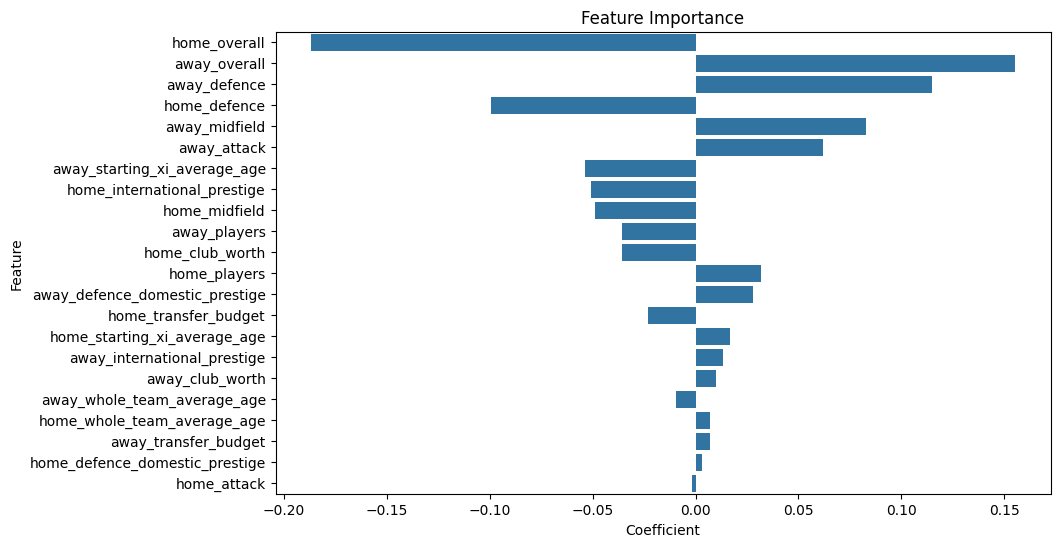

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Coefficient', y='Feature', ax=ax)
plt.title('Feature Importance')
plt.show()


In [ ]:
fbref_df_date_filtered_concat_no_nan[['home_overall', 'away_overall', 'away_defence', 'home_defence',
       'away_midfield', 'away_attack', 'away_starting_xi_average_age',
       'home_international_prestige', 'home_midfield', 'away_players',
       'home_club_worth', 'home_players',
       'away_defence_domestic_prestige', 'home_transfer_budget',
       'home_starting_xi_average_age', 'away_international_prestige',
       'away_club_worth', 'away_whole_team_average_age',
       'home_whole_team_average_age', 'away_transfer_budget',
       'home_defence_domestic_prestige', 'home_attack']]

,home_overall,away_overall,away_defence,home_defence,away_midfield,away_attack,away_starting_xi_average_age,home_international_prestige,home_midfield,away_players,...,away_defence_domestic_prestige,home_transfer_budget,home_starting_xi_average_age,away_international_prestige,away_club_worth,away_whole_team_average_age,home_whole_team_average_age,away_transfer_budget,home_defence_domestic_prestige,home_attack
0,82.0,75.0,75.0,81.0,75.0,74.0,23.55,9.0,83.0,33.0,...,7.0,0.0,29.18,6.0,5.300000e+06,22.48,26.18,0.0,9.0,84.0
1,81.0,81.0,80.0,82.0,81.0,81.0,24.55,8.0,78.0,31.0,...,7.0,0.0,24.18,7.0,2.600000e+10,23.74,24.18,0.0,9.0,78.0
2,84.0,76.0,75.0,84.0,76.0,77.0,27.64,10.0,84.0,33.0,...,5.0,0.0,27.91,1.0,1.500000e+05,24.82,23.24,0.0,10.0,84.0
3,78.0,83.0,82.0,74.0,83.0,83.0,28.82,5.0,78.0,26.0,...,10.0,0.0,26.73,8.0,1.000000e+09,27.77,25.30,0.0,6.0,78.0
10,76.0,83.0,83.0,76.0,80.0,84.0,26.27,4.0,76.0,33.0,...,9.0,0.0,28.18,9.0,4.600000e+10,23.76,25.13,0.0,3.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31695,72.0,80.0,79.0,73.0,80.0,83.0,27.27,1.0,72.0,30.0,...,8.0,0.0,26.27,7.0,6.600000e+06,25.17,25.18,0.0,2.0,72.0
31696,73.0,73.0,72.0,72.0,74.0,73.0,28.27,1.0,74.0,30.0,...,2.0,750000.0,26.45,1.0,6.630000e+06,26.93,25.67,0.0,2.0,73.0
31697,73.0,71.0,71.0,72.0,69.0,73.0,26.82,3.0,73.0,27.0,...,1.0,1210000.0,25.18,1.0,7.000000e+05,24.48,23.79,0.0,6.0,75.0
31698,71.0,73.0,72.0,71.0,73.0,75.0,25.18,1.0,69.0,33.0,...,6.0,0.0,26.82,3.0,9.500000e+05,23.79,24.48,1210000.0,1.0,73.0


In [ ]:
X_col_top = ['home_overall', 'away_overall', 'away_defence', 'home_defence',
       'away_midfield', 'away_attack', 'away_starting_xi_average_age',
       'home_international_prestige', 'home_midfield', 'away_players',
       'home_club_worth', 'home_players',
       'away_defence_domestic_prestige', 'home_transfer_budget',
       'home_starting_xi_average_age', 'away_international_prestige',
       'away_club_worth', 'away_whole_team_average_age',
       'home_whole_team_average_age', 'away_transfer_budget',
       'home_defence_domestic_prestige', 'home_attack']

In [ ]:
matchs = fbref_df_date_filtered_concat_no_nan
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])
X_col =  X_col_top[:10]

Y_col = 'FTR'

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.525865
1,weighted_accuracy,0.667760
2,accuracy_home,0.593625
3,accuracy_draw,0.741166
4,accuracy_away,0.716940
5,recall_all,1.341650
6,weighted_recall,0.525865
7,balanced_accuracy,0.447217
8,recall_home,0.852666
9,recall_draw,0.000722


### 3.10 Log reg on only international teams

In [ ]:
fbref_df_date_filtered_concat_no_nan["league"].unique()

array(['ESP-La Liga', 'ENG-Premier League', 'ITA-Serie A', 'FRA-Ligue 1',
       'GER-Bundesliga', 'INT-European Championships', 'INT-World Cup'],
      dtype=object)

In [ ]:
fbref_df_date_filtered_concat_no_nan[fbref_df_date_filtered_concat_no_nan["league"].isin(['INT-European Championships', 'INT-World Cup'])]

,game_id,league,season,game,round,week,day,date,time,home_team,...,away_starting_xi_average_age,away_whole_team_average_age,away_fifa_edition,away_update,FTR,results_home_always_win,results_home,results_home_always_win_prob_home,results_home_always_win_prob_away,results_home_always_win_prob_draw
2893,6a5972c3,INT-European Championships,0809,2008-06-08 Germany-Poland,Group stage,1.0,Sun,2008-06-08,20:45:00,Germany,...,26.91,26.50,FIFA 08,2008-02-22,1,1,1,1,0,0
2894,d5574cb6,INT-European Championships,0809,2008-06-09 Romania-France,Group stage,1.0,Mon,2008-06-09,18:00:00,Romania,...,27.27,25.65,FIFA 08,2008-02-22,0,1,-1,1,0,0
2895,e53203ac,INT-European Championships,0809,2008-06-09 Netherlands-Italy,Group stage,1.0,Mon,2008-06-09,20:45:00,Netherlands,...,28.18,27.04,FIFA 08,2008-02-22,1,1,1,1,0,0
2899,62873a71,INT-European Championships,0809,2008-06-11 Czechia-Portugal,Group stage,2.0,Wed,2008-06-11,18:00:00,Czechia,...,26.91,27.00,FIFA 08,2008-02-22,-1,1,-1,1,0,0
2901,04c62d77,INT-European Championships,0809,2008-06-12 Croatia-Germany,Group stage,2.0,Thu,2008-06-12,18:00:00,Croatia,...,27.73,28.04,FIFA 08,2008-02-22,1,1,-1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28895,170c8725,INT-World Cup,2223,2022-12-10 Morocco-Portugal,Quarter-finals,NaN,Sat,2022-12-10,18:00:00,Morocco,...,29.36,26.96,FIFA 23,2022-12-06,1,1,-1,1,0,0
28896,0b527037,INT-World Cup,2223,2022-12-13 Argentina-Croatia,Semi-finals,NaN,Tue,2022-12-13,22:00:00,Argentina,...,28.45,27.43,FIFA 23,2022-12-06,1,1,1,1,0,0
28897,85c72a0a,INT-World Cup,2223,2022-12-14 France-Morocco,Semi-finals,NaN,Wed,2022-12-14,22:00:00,France,...,26.36,25.78,FIFA 23,2022-12-06,1,1,1,1,0,0
28898,9d73d381,INT-World Cup,2223,2022-12-17 Croatia-Morocco,Third-place match,NaN,Sat,2022-12-17,18:00:00,Croatia,...,26.36,26.52,FIFA 23,2022-12-17,1,1,1,1,0,0


#### 3.10.1 Train test on international teams data (expanding windows)

In [ ]:
matchs = fbref_df_date_filtered_concat_no_nan[fbref_df_date_filtered_concat_no_nan["league"].isin(['INT-European Championships', 'INT-World Cup'])]
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])
X_col =  X_col_top[:2]

Y_col = 'FTR'

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.516667
1,weighted_accuracy,0.641667
2,accuracy_home,0.650000
3,accuracy_draw,0.733333
4,accuracy_away,0.650000
5,recall_all,1.238095
6,weighted_recall,0.516667
7,balanced_accuracy,0.412698
8,recall_home,0.618095
9,recall_draw,0.000000


In [ ]:
fbref_df_date_filtered_concat_no_nan

,game_id,league,season,game,round,week,day,date,time,home_team,...,away_starting_xi_average_age,away_whole_team_average_age,away_fifa_edition,away_update,FTR,results_home_always_win,results_home,results_home_always_win_prob_home,results_home_always_win_prob_away,results_home_always_win_prob_draw
0,ffc11029,ESP-La Liga,0607,2006-09-09 Atlético Madrid-Valencia,None,2.0,Sat,2006-09-09,None,Atlético Madrid,...,23.55,22.48,FIFA 07,2006-08-30,-1,1,1,1,0,0
1,dc45f23c,ENG-Premier League,0607,2006-09-09 Manchester Utd-Tottenham,None,4.0,Sat,2006-09-09,None,Manchester Utd,...,24.55,23.74,FIFA 07,2006-08-30,1,1,1,1,0,0
2,5c7a478f,ESP-La Liga,0607,2006-09-09 Barcelona-Osasuna,None,2.0,Sat,2006-09-09,None,Barcelona,...,27.64,24.82,FIFA 07,2006-08-30,1,1,1,1,0,0
3,36cd8447,ITA-Serie A,0607,2006-09-09 Fiorentina-Inter,None,1.0,Sat,2006-09-09,None,Fiorentina,...,28.82,27.77,FIFA 07,2006-08-30,-1,1,-1,1,0,0
10,880e137f,ENG-Premier League,0607,2006-09-09 Everton-Liverpool,None,4.0,Sat,2006-09-09,None,Everton,...,26.27,23.76,FIFA 07,2006-08-30,1,1,-1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31695,2ee9be16,ITA-Serie A,2324,2024-05-26 Empoli-Roma,None,38.0,Sun,2024-05-26,20:45:00,Empoli,...,27.27,25.17,FC 24,2024-05-22,1,1,-1,1,0,0
31696,723ffa45,GER-Bundesliga,2324,2024-05-27 Düsseldorf-Bochum,German 1/2 Relegation/Promotion Play-offs,NaN,Mon,2024-05-27,20:30:00,Düsseldorf,...,28.27,26.93,FC 24,2024-05-22,-1,1,1,1,0,0
31697,febd4e01,FRA-Ligue 1,2324,2024-05-30 Saint-Étienne-Metz,French 1/2 Relegation/Promotion Play-off,NaN,Thu,2024-05-30,20:30:00,Saint-Étienne,...,26.82,24.48,FC 24,2024-05-22,1,1,1,1,0,0
31698,7f01f697,FRA-Ligue 1,2324,2024-06-02 Metz-Saint-Étienne,French 1/2 Relegation/Promotion Play-off,NaN,Sun,2024-06-02,17:00:00,Metz,...,25.18,23.79,FIFA 22,2022-08-18,0,1,-1,1,0,0


#### 3.10.2 Train on non-international teams, test on international teams

In [ ]:
train = fbref_df_date_filtered_concat_no_nan[~fbref_df_date_filtered_concat_no_nan["league"].isin(['INT-European Championships', 'INT-World Cup'])]
test = fbref_df_date_filtered_concat_no_nan[fbref_df_date_filtered_concat_no_nan["league"].isin(['INT-European Championships', 'INT-World Cup'])]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

X_col =  X_col_top[:10]

Y_col = 'FTR'

pipeline.fit(train[X_col], train[Y_col])
results = pipeline.predict(test[X_col])
test["results"] = results
accuracy = accuracy_fn(test, 'FTR', "results")
accuracy

C:\Users\jdelavande\AppData\Local\Temp\ipykernel_2084\1354950942.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["results"] = results


(0.5251572327044025,
 0.6718780902654167,
 (0.5974842767295597, 0.7578616352201258, 0.6949685534591195))

In [ ]:
train = fbref_df_date_filtered_concat_no_nan[~fbref_df_date_filtered_concat_no_nan["league"].isin(['INT-European Championships', 'INT-World Cup'])]
test = fbref_df_date_filtered_concat_no_nan[fbref_df_date_filtered_concat_no_nan["league"].isin(['INT-European Championships', 'INT-World Cup'])]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

X_col =  X_col_top[:2]

Y_col = 'FTR'

test["results"] = 1
accuracy = accuracy_fn(test, 'FTR', "results")
accuracy

C:\Users\jdelavande\AppData\Local\Temp\ipykernel_2084\3766039836.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["results"] = 1


(0.39308176100628933,
 0.5697361654997825,
 (0.39308176100628933, 0.7578616352201258, 0.6352201257861635))

In [ ]:
fbref_df_date_filtered_concat_no_nan[~fbref_df_date_filtered_concat_no_nan["league"].isin(['INT-European Championships', 'INT-World Cup'])]

,game_id,league,season,game,round,week,day,date,time,home_team,...,away_starting_xi_average_age,away_whole_team_average_age,away_fifa_edition,away_update,FTR,results_home_always_win,results_home,results_home_always_win_prob_home,results_home_always_win_prob_away,results_home_always_win_prob_draw
0,ffc11029,ESP-La Liga,0607,2006-09-09 Atlético Madrid-Valencia,None,2.0,Sat,2006-09-09,None,Atlético Madrid,...,23.55,22.48,FIFA 07,2006-08-30,-1,1,1,1,0,0
1,dc45f23c,ENG-Premier League,0607,2006-09-09 Manchester Utd-Tottenham,None,4.0,Sat,2006-09-09,None,Manchester Utd,...,24.55,23.74,FIFA 07,2006-08-30,1,1,1,1,0,0
2,5c7a478f,ESP-La Liga,0607,2006-09-09 Barcelona-Osasuna,None,2.0,Sat,2006-09-09,None,Barcelona,...,27.64,24.82,FIFA 07,2006-08-30,1,1,1,1,0,0
3,36cd8447,ITA-Serie A,0607,2006-09-09 Fiorentina-Inter,None,1.0,Sat,2006-09-09,None,Fiorentina,...,28.82,27.77,FIFA 07,2006-08-30,-1,1,-1,1,0,0
10,880e137f,ENG-Premier League,0607,2006-09-09 Everton-Liverpool,None,4.0,Sat,2006-09-09,None,Everton,...,26.27,23.76,FIFA 07,2006-08-30,1,1,-1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31695,2ee9be16,ITA-Serie A,2324,2024-05-26 Empoli-Roma,None,38.0,Sun,2024-05-26,20:45:00,Empoli,...,27.27,25.17,FC 24,2024-05-22,1,1,-1,1,0,0
31696,723ffa45,GER-Bundesliga,2324,2024-05-27 Düsseldorf-Bochum,German 1/2 Relegation/Promotion Play-offs,NaN,Mon,2024-05-27,20:30:00,Düsseldorf,...,28.27,26.93,FC 24,2024-05-22,-1,1,1,1,0,0
31697,febd4e01,FRA-Ligue 1,2324,2024-05-30 Saint-Étienne-Metz,French 1/2 Relegation/Promotion Play-off,NaN,Thu,2024-05-30,20:30:00,Saint-Étienne,...,26.82,24.48,FC 24,2024-05-22,1,1,1,1,0,0
31698,7f01f697,FRA-Ligue 1,2324,2024-06-02 Metz-Saint-Étienne,French 1/2 Relegation/Promotion Play-off,NaN,Sun,2024-06-02,17:00:00,Metz,...,25.18,23.79,FIFA 22,2022-08-18,0,1,-1,1,0,0


In [ ]:
matchs = fbref_df_date_filtered_concat_no_nan[fbref_df_date_filtered_concat_no_nan["league"].isin(['INT-European Championships', 'INT-World Cup'])]
matchs["results_home_always_win"] = 1
matchs["results_home_always_win_prob_home"] = 1
matchs["results_home_always_win_prob_away"] = 0
matchs["results_home_always_win_prob_draw"] = 0

X_col =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

Y_col = 'FTR'

train_test_split =  train_test_split_expanding_windows(matchs, split=5, test_prop=0.2, date_col="date")

accuracy_split_test = []
for train, test in train_test_split:
    test["results_home_always_win"] = 1
    accuracy_split_test.append(accuracy_fn(test, 'FTR', "results_home_always_win"))

accuracy_split_test

C:\Users\jdelavande\AppData\Local\Temp\ipykernel_2084\2451947422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matchs["results_home_always_win"] = 1
C:\Users\jdelavande\AppData\Local\Temp\ipykernel_2084\2451947422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matchs["results_home_always_win_prob_home"] = 1
C:\Users\jdelavande\AppData\Local\Temp\ipykernel_2084\2451947422.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

[(0.5, 0.5694444444444444, (0.5, 0.9166666666666666, 0.5833333333333334)),
 (0.4166666666666667,
  0.5833333333333334,
  (0.4166666666666667, 0.6666666666666666, 0.75)),
 (0.4166666666666667,
  0.5555555555555556,
  (0.4166666666666667, 0.8333333333333334, 0.5833333333333334)),
 (0.16666666666666666, 0.5, (0.16666666666666666, 0.6666666666666666, 0.5)),
 (0.5833333333333334,
  0.6388888888888888,
  (0.5833333333333334, 0.6666666666666666, 0.9166666666666666))]

### 3.11 Log reg on on all sofiifa features

In [257]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

matchs = fbref_df_date_filtered_concat_no_nan

categorical_features = ['home_build_up_speed', 'home_build_up_dribbling', 'home_build_up_passing', 'home_build_up_positioning',
                        'home_chance_creation_crossing', 'home_chance_creation_passing', 'home_chance_creation_shooting', 
                        'home_chance_creation_positioning', 'home_defence_aggression', 'home_defence_pressure', 
                        'home_defence_team_width', 'home_defence_defender_line', 'home_fifa_edition', 'away_league',
                        'away_build_up_speed', 'away_build_up_dribbling', 'away_build_up_passing', 'away_build_up_positioning',
                        'away_chance_creation_crossing', 'away_chance_creation_passing', 'away_chance_creation_shooting', 
                        'away_chance_creation_positioning', 'away_defence_aggression', 'away_defence_pressure', 
                        'away_defence_team_width', 'away_defence_defender_line', 'away_fifa_edition']

numerical_features = ['home_overall', 'home_attack', 'home_midfield', 'home_defence', 'home_transfer_budget', 
                      'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 'home_players', 
                      'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 
                      'away_midfield', 'away_defence', 'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 
                      'away_international_prestige', 'away_players', 'away_starting_xi_average_age', 'away_whole_team_average_age']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

X_col =  numerical_features + categorical_features
Y_col = 'FTR'

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

,metrics,values
0,accuracy,0.512386
1,weighted_accuracy,0.661243
2,accuracy_home,0.605647
3,accuracy_draw,0.716758
4,accuracy_away,0.702368
5,recall_all,1.325159
6,weighted_recall,0.512386
7,balanced_accuracy,0.441720
8,recall_home,0.783585
9,recall_draw,0.063582


### 3.12 Random Forest on all sofifa features

In [102]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

matchs = fbref_df_date_filtered_concat_no_nan

categorical_features = ['home_build_up_speed', 'home_build_up_dribbling', 'home_build_up_passing', 'home_build_up_positioning',
                        'home_chance_creation_crossing', 'home_chance_creation_passing', 'home_chance_creation_shooting', 
                        'home_chance_creation_positioning', 'home_defence_aggression', 'home_defence_pressure', 
                        'home_defence_team_width', 'home_defence_defender_line', 'home_fifa_edition', 'away_league',
                        'away_build_up_speed', 'away_build_up_dribbling', 'away_build_up_passing', 'away_build_up_positioning',
                        'away_chance_creation_crossing', 'away_chance_creation_passing', 'away_chance_creation_shooting', 
                        'away_chance_creation_positioning', 'away_defence_aggression', 'away_defence_pressure', 
                        'away_defence_team_width', 'away_defence_defender_line', 'away_fifa_edition']

numerical_features = ['home_overall', 'home_attack', 'home_midfield', 'home_defence', 'home_transfer_budget', 
                      'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 'home_players', 
                      'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 
                      'away_midfield', 'away_defence', 'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 
                      'away_international_prestige', 'away_players', 'away_starting_xi_average_age', 'away_whole_team_average_age']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
])

X_col =  numerical_features + categorical_features
Y_col = 'FTR'

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.500729
1,weighted_accuracy,0.657602
2,accuracy_home,0.612933
3,accuracy_draw,0.690528
4,accuracy_away,0.697996
5,recall_all,1.340895
6,weighted_recall,0.500729
7,balanced_accuracy,0.446965
8,recall_home,0.716698
9,recall_draw,0.151154


### 3.13 Gradient Boosting on all sofifa features

In [103]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

matchs = fbref_df_date_filtered_concat_no_nan

categorical_features = ['home_build_up_speed', 'home_build_up_dribbling', 'home_build_up_passing', 'home_build_up_positioning',
                        'home_chance_creation_crossing', 'home_chance_creation_passing', 'home_chance_creation_shooting', 
                        'home_chance_creation_positioning', 'home_defence_aggression', 'home_defence_pressure', 
                        'home_defence_team_width', 'home_defence_defender_line', 'home_fifa_edition', 'away_league',
                        'away_build_up_speed', 'away_build_up_dribbling', 'away_build_up_passing', 'away_build_up_positioning',
                        'away_chance_creation_crossing', 'away_chance_creation_passing', 'away_chance_creation_shooting', 
                        'away_chance_creation_positioning', 'away_defence_aggression', 'away_defence_pressure', 
                        'away_defence_team_width', 'away_defence_defender_line', 'away_fifa_edition']

numerical_features = ['home_overall', 'home_attack', 'home_midfield', 'home_defence', 'home_transfer_budget', 
                      'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 'home_players', 
                      'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 
                      'away_midfield', 'away_defence', 'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 
                      'away_international_prestige', 'away_players', 'away_starting_xi_average_age', 'away_whole_team_average_age']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier())
])

X_col =  numerical_features + categorical_features
Y_col = 'FTR'

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.517486
1,weighted_accuracy,0.663840
2,accuracy_home,0.600182
3,accuracy_draw,0.722404
4,accuracy_away,0.712386
5,recall_all,1.334729
6,weighted_recall,0.517486
7,balanced_accuracy,0.444910
8,recall_home,0.810095
9,recall_draw,0.037599


### 3.14 Different dataset sizes Log reg

In [62]:
import matplotlib.pyplot as plt
df_size = fbref_df_date_filtered_concat_no_nan.shape[0]
step = 100
metrics_mean_by_step = []
size = []

for i in range(0, step):
    start = int(i*df_size/step)
    matchs = fbref_df_date_filtered_concat_no_nan[start:]
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])
    X_col =  ['home_overall', 'home_attack', 
            'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
            'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
            'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
            'away_starting_xi_average_age', 'away_whole_team_average_age']

    Y_col = 'FTR'

    train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
    result_df_all_splits = False
    m = 10
    beta = 1

    metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
    metrics_mean_by_step.append(metrics_mean)
    size.append(df_size - start)


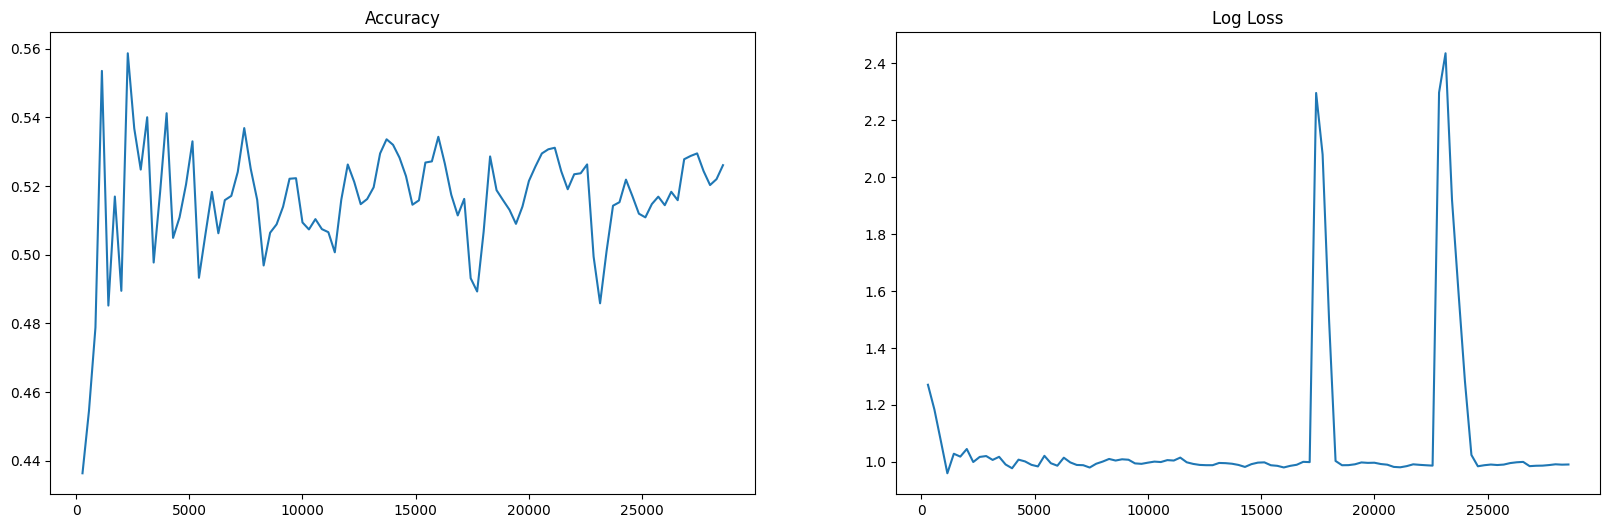

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].plot(size, [metric["accuracy"] for metric in metrics_mean_by_step], label='Accuracy')
ax[0].set_title('Accuracy')
ax[1].plot(size, [metric["log_loss"] for metric in metrics_mean_by_step], label='Log Loss')
ax[1].set_title('Log Loss')
plt.show()


In [108]:
import matplotlib.pyplot as plt
df_size = fbref_df_date_filtered_concat_no_nan.shape[0]
step = 1000
test_size = 0.2
metrics_mean_by_step = []
size = []

for i in range(0, step):
    start_test = int((1-test_size)*df_size)
    start_train = int(i*start_test/step)
    matchs_test = fbref_df_date_filtered_concat_no_nan[start_test:]
    matchs_train = fbref_df_date_filtered_concat_no_nan[start_train:start_test]
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])
    X_col =  ['home_overall', 'home_attack', 
            'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
            'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
            'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
            'away_starting_xi_average_age', 'away_whole_team_average_age']

    Y_col = 'FTR'

    pipeline.fit(matchs_train[X_col], matchs_train[Y_col])
    results = pipeline.predict(matchs_test[X_col])
    results_prob = pipeline.predict_proba(matchs_test[X_col])

    result_df = pd.DataFrame(results_prob, columns=['results_prob_away', 'results_prob_draw', 'results_prob_home'])

    result_df["results"] = results
    result_df["FTR"] = matchs_test["FTR"].values

    accuracy, _, _ = accuracy_fn(result_df, 'FTR', "results")
    log_loss = log_loss_fn(result_df["results"], result_df['results_prob_away'], result_df['results_prob_draw'], result_df['results_prob_home'])
    
    metrics_mean_by_step.append({"accuracy": accuracy, "log_loss": log_loss})
    size.append(df_size - start_train)



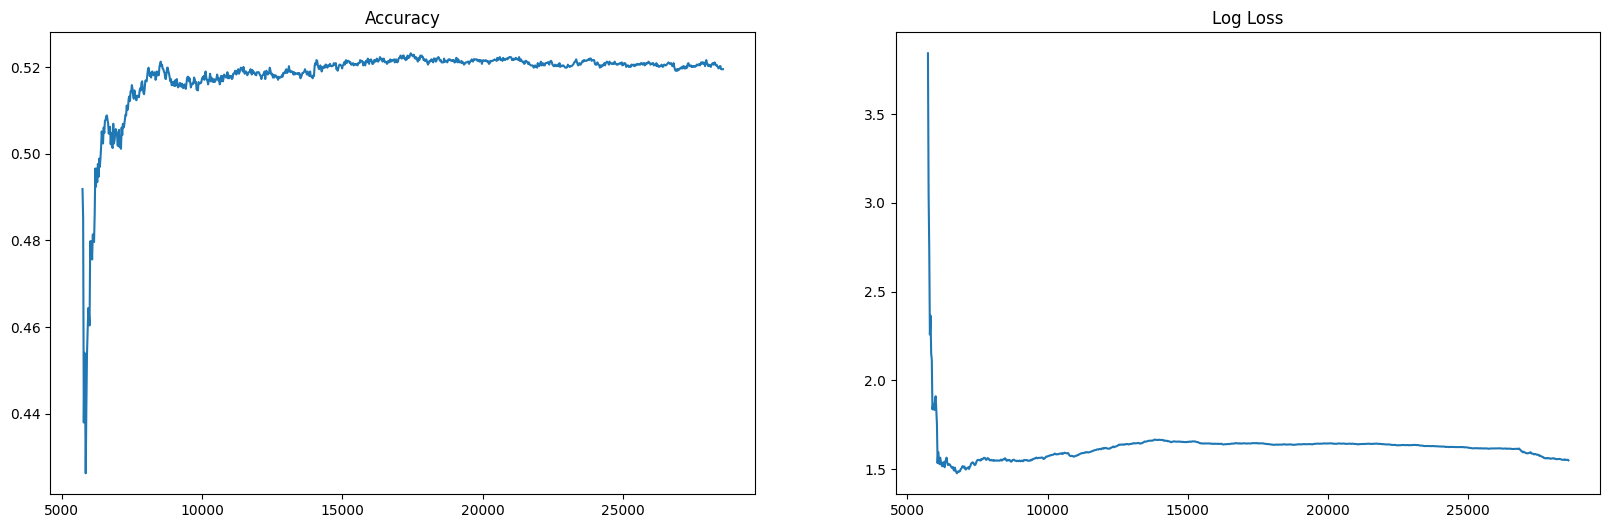

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].plot(size, [metric["accuracy"] for metric in metrics_mean_by_step], label='Accuracy')
ax[0].set_title('Accuracy')
ax[1].plot(size, [metric["log_loss"] for metric in metrics_mean_by_step], label='Log Loss')
ax[1].set_title('Log Loss')
plt.show()


In [140]:
from train_test.split import train_test_split_expanding_windows
from train_test.metrics import accuracy_fn, recall_fn, precision_fn, f_mesure_fn, log_loss_fn, mse_loss_fn, classwise_ECE_fn
import numpy as np
import numbers
import pandas as pd

def create_weights(length, decay_rate=0.01):
    return np.exp(-decay_rate * np.arange(length))


In [125]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class WeightedStandardScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, sample_weight=None):
        if sample_weight is None:
            self.mean_ = np.mean(X, axis=0)
            self.scale_ = np.std(X, axis=0)
        else:
            self.mean_ = np.average(X, axis=0, weights=sample_weight)
            self.scale_ = np.sqrt(np.average((X - self.mean_)**2, axis=0, weights=sample_weight))
        return self

    def transform(self, X):
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X, y=None, sample_weight=None):
        return self.fit(X, y, sample_weight).transform(X)


In [171]:
decay_rate_list = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0]
metrics_list = []

for decay_rate in decay_rate_list:
    df_size = fbref_df_date_filtered_concat_no_nan.shape[0]
    pipeline = Pipeline([
        ('scaler', WeightedStandardScaler()),
        ('model', LogisticRegression())
    ])
    X_col =  ['home_overall', 'home_attack', 
            'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
            'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
            'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
            'away_starting_xi_average_age', 'away_whole_team_average_age']

    Y_col = 'FTR'


    train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
    result_df_all_splits = False
    m = 10
    beta = 1


    matchs = fbref_df_date_filtered_concat_no_nan
    train_test_split = train_test_split_fn(matchs)

    keys = ["accuracy", "weighted_accuracy", "accuracy_home", "accuracy_draw", "accuracy_away",
                "recall_all", "weighted_recall", "balanced_accuracy", "recall_home", "recall_draw", "recall_away",
                "precision_all", "weighted_precision", "precision_home", "precision_draw", "precision_away",
                "f_mesure_all", "f_mesure_weighted", "f_mesure_home", "f_mesure_draw", "f_mesure_away",
                "log_loss", "loss_home", "loss_draw", "loss_away",
                "mse", "mse_home", "mse_draw", "mse_away",
                "classwise_ECE", "ECE_home", "ECE_draw", "ECE_away", "home_ECE_y", "draw_ECE_y", "away_ECE_y", "home_ECE_p", "draw_ECE_p", "away_ECE_p", "home_ECE_size", "draw_ECE_size", "away_ECE_size"]


    metrics = {key: [0 for _ in range(len(train_test_split))] for key in keys}

    result_df_all_splits = []
    model_predictions_col_name = 'model_predictions'
    model_predictions_prob_home_col_name = 'model_predictions_prob_home'
    model_predictions_prob_draw_col_name = 'model_predictions_prob_draw'
    model_predictions_prob_away_col_name = 'model_predictions_prob_away'
    result_col_name = 'FTR'

    for i, (train, test) in enumerate(train_test_split):
        X_train = train[X_col]
        Y_train = train[Y_col]
        X_test = test[X_col]
        weights = create_weights(X_train.shape[0], decay_rate)

        pipeline_args = {"scaler__sample_weight": weights, "model__sample_weight": weights}

        pipeline.fit(X_train, Y_train.values.ravel(), **pipeline_args)
        predictions = pipeline.predict(X_test)
        prob_predictions = pipeline.predict_proba(X_test)

        result_df = test.copy()
        result_df.reset_index(inplace=True)
        result_df = result_df.merge(pd.DataFrame(predictions, columns=[model_predictions_col_name]), how='left', on=result_df.index)
        result_df = result_df.drop(columns=['key_0'])
        result_df = result_df.merge(pd.DataFrame(prob_predictions, columns=[model_predictions_prob_away_col_name, model_predictions_prob_draw_col_name, model_predictions_prob_home_col_name]), how='left', on=result_df.index)

        metrics["accuracy"][i], metrics["weighted_accuracy"][i], (metrics["accuracy_home"][i], metrics["accuracy_draw"][i], metrics["accuracy_away"][i]) = accuracy_fn(result_df, result_col_name, model_predictions_col_name)
        metrics["recall_all"][i], metrics["weighted_recall"][i], metrics["balanced_accuracy"][i], (metrics["recall_home"][i], metrics["recall_draw"][i], metrics["recall_away"][i]) = recall_fn(result_df, result_col_name, model_predictions_col_name)
        metrics["precision_all"][i], metrics["weighted_precision"][i], (metrics["precision_home"][i], metrics["precision_draw"][i], metrics["precision_away"][i]) = precision_fn(result_df, result_col_name, model_predictions_col_name)
        metrics["f_mesure_all"][i], metrics["f_mesure_weighted"][i], (metrics["f_mesure_home"][i], metrics["f_mesure_draw"][i], metrics["f_mesure_away"][i]) = f_mesure_fn(result_df, result_col_name, model_predictions_col_name, beta=beta)
        metrics["log_loss"][i], (metrics["loss_home"][i], metrics["loss_draw"][i], metrics["loss_away"][i]) = log_loss_fn(result_df[result_col_name], result_df[model_predictions_prob_home_col_name], result_df[model_predictions_prob_draw_col_name], result_df[model_predictions_prob_away_col_name], all_results=True)
        metrics["mse"][i], (metrics["mse_home"][i], metrics["mse_draw"][i], metrics["mse_away"][i]) = mse_loss_fn(result_df[result_col_name], result_df[model_predictions_prob_home_col_name], result_df[model_predictions_prob_draw_col_name], result_df[model_predictions_prob_away_col_name], all_results=True)
        metrics["classwise_ECE"][i], (metrics["ECE_home"][i], metrics["ECE_draw"][i], metrics["ECE_away"][i]), (metrics["home_ECE_y"][i], metrics["draw_ECE_y"][i], metrics["away_ECE_y"][i]), (metrics["home_ECE_p"][i], metrics["draw_ECE_p"][i], metrics["away_ECE_p"][i]), (metrics["home_ECE_size"][i], metrics["draw_ECE_size"][i], metrics["away_ECE_size"][i]) = classwise_ECE_fn(result_df[result_col_name], result_df[model_predictions_prob_home_col_name], result_df[model_predictions_prob_draw_col_name], result_df[model_predictions_prob_away_col_name], all_results=True, m=m)

        metrics_mean = {key: np.mean(value) for key, value in metrics.items() if isinstance(value[0], numbers.Real)}
        

    metrics_list.append(metrics_mean)




In [166]:
[metric["accuracy"] for metric in metrics_list]

[0.3105646630236794,
 0.3211293260473588,
 0.33843351548269585,
 0.3673952641165755,
 0.3797814207650273,
 0.4129326047358834,
 0.4998178506375228,
 0.5171220400728598,
 0.5271402550091076,
 0.5260473588342441]

In [172]:
decay_rate_list

[0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 0]

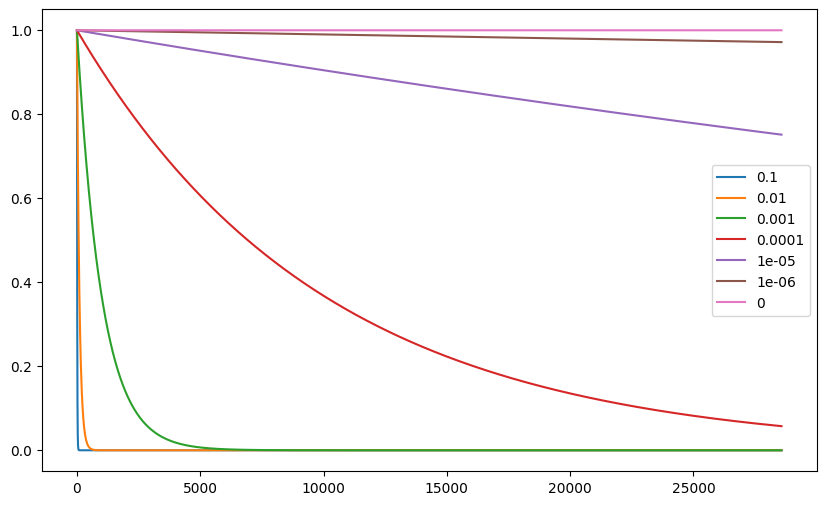

In [177]:
fig, ax = plt.subplots(figsize=(10, 6))
[ax.plot(create_weights(df_size, decay_rate), label=decay_rate) for decay_rate in decay_rate_list]
ax.legend()
plt.show()

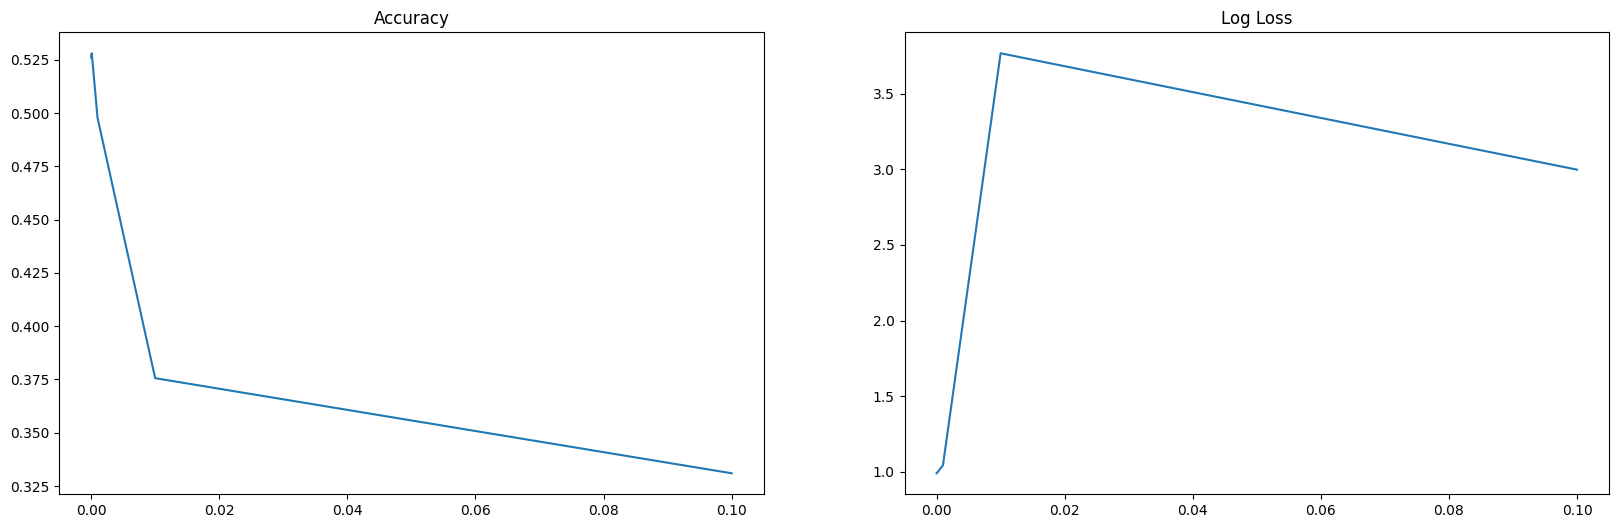

In [178]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].plot(decay_rate_list, [metric["accuracy"] for metric in metrics_list], label='Accuracy')
ax[0].set_title('Accuracy')
ax[1].plot(decay_rate_list, [metric["log_loss"] for metric in metrics_list], label='Log Loss')
ax[1].set_title('Log Loss')
plt.show()

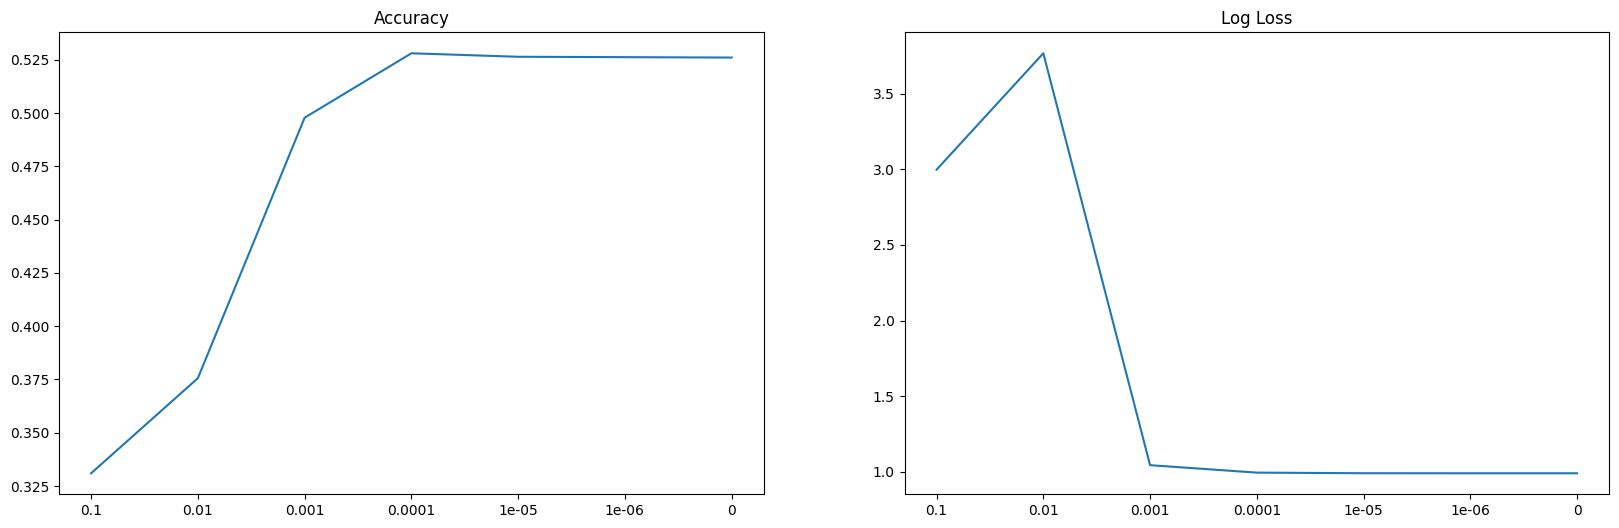

In [179]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].plot([str(decay_rate) for decay_rate in decay_rate_list], [metric["accuracy"] for metric in metrics_list], label='Accuracy')
ax[0].set_title('Accuracy')
ax[1].plot([str(decay_rate) for decay_rate in decay_rate_list], [metric["log_loss"] for metric in metrics_list], label='Log Loss')
ax[1].set_title('Log Loss')
plt.show()

In [185]:
matchs = fbref_df_date_filtered_concat_no_nan
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])
X_col =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

Y_col = 'FTR'

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.526047
1,weighted_accuracy,0.666927
2,accuracy_home,0.589617
3,accuracy_draw,0.741712
4,accuracy_away,0.720765
5,recall_all,1.332199
6,weighted_recall,0.526047
7,balanced_accuracy,0.444066
8,recall_home,0.860336
9,recall_draw,0.000725


In [186]:
metrics

{'accuracy': [0.5,
  0.5418943533697632,
  0.5336976320582878,
  0.5391621129326047,
  0.5154826958105647],
 'weighted_accuracy': [0.6394214020524152,
  0.6787469185570054,
  0.6720946513117078,
  0.6808719944525732,
  0.6634981303977093],
 'accuracy_home': [0.5255009107468124,
  0.6156648451730419,
  0.5974499089253188,
  0.6174863387978142,
  0.5919854280510018],
 'accuracy_draw': [0.7222222222222222,
  0.7468123861566485,
  0.7431693989071039,
  0.7568306010928961,
  0.7395264116575592],
 'accuracy_away': [0.7522768670309654,
  0.7213114754098361,
  0.726775956284153,
  0.7040072859744991,
  0.6994535519125683],
 'recall_all': [1.1860186473123908,
  1.372378562910715,
  1.3583291139240505,
  1.394830160507652,
  1.349436995980326],
 'weighted_recall': [0.5,
  0.5418943533697632,
  0.5336976320582878,
  0.5391621129326047,
  0.5154826958105646],
 'balanced_accuracy': [0.3953395491041303,
  0.45745952097023834,
  0.45277637130801685,
  0.46494338683588404,
  0.449812331993442],
 'reca

In [183]:
matchs = fbref_df_date_filtered_concat_no_nan
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])
X_col =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

Y_col = 'FTR'

train_test_split_fn = lambda df : train_test_split_sliding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.524772
1,weighted_accuracy,0.666674
2,accuracy_home,0.594171
3,accuracy_draw,0.740437
4,accuracy_away,0.714936
5,recall_all,1.333855
6,weighted_recall,0.524772
7,balanced_accuracy,0.444618
8,recall_home,0.846523
9,recall_draw,0.005700


In [184]:
metrics

{'accuracy': [0.5,
  0.5428051001821493,
  0.5336976320582878,
  0.5182149362477231,
  0.529143897996357],
 'weighted_accuracy': [0.6394214020524152,
  0.6806895133061934,
  0.673552841563233,
  0.6659948042640867,
  0.6737137567559497],
 'accuracy_home': [0.5255009107468124,
  0.6229508196721312,
  0.6056466302367942,
  0.6102003642987249,
  0.6065573770491803],
 'accuracy_draw': [0.7222222222222222,
  0.7431693989071039,
  0.7404371584699454,
  0.7568306010928961,
  0.7395264116575592],
 'accuracy_away': [0.7522768670309654,
  0.7194899817850637,
  0.7213114754098361,
  0.6693989071038251,
  0.7122040072859745],
 'recall_all': [1.1860186473123908,
  1.3776603031800696,
  1.3652965257204417,
  1.3462579320642032,
  1.3940426661945649],
 'weighted_recall': [0.5,
  0.5428051001821493,
  0.5336976320582878,
  0.5182149362477231,
  0.529143897996357],
 'balanced_accuracy': [0.3953395491041303,
  0.4592201010600232,
  0.4550988419068139,
  0.4487526440214011,
  0.46468088873152164],
 'reca

In [196]:
import pandas as pd
import math

# Fonction principale pour ajouter les scores Glicko-2
def glicko2_scores(df, TAU=0.5,  START_RATING=1500., START_RD=350., START_VOL=0.06, CONVERGENCE_TOLERANCE=1e-5,
                home_team_id_col='home_team_api_id', away_team_id_col='away_team_api_id',
                home_team_goal_col='home_team_goal', away_team_goal_col='away_team_goal',
                glicko2_home_before_col='glicko2_home_before', glicko2_away_before_col='glicko2_away_before',
                glicko2_rd_home_before_col='glicko2_rd_home_before', glicko2_rd_away_before_col='glicko2_rd_away_before',
                glicko2_vol_home_before_col='glicko2_vol_home_before', glicko2_vol_away_before_col='glicko2_vol_away_before'):
    """
    Add the Glicko-2 scores to the dataset.

    Parameters
    ----------
    df : pd.DataFrame
        The dataset to add the Glicko-2 scores.
    TAU : float, optional
        The system constant. The default is 0.5.
    START_RATING : float, optional
        The starting rating. The default is 1500.
    START_RD : float, optional
        The starting rating deviation. The default is 350.
    START_VOL : float, optional
        The starting volatility. The default is 0.06.
    CONVERGENCE_TOLERANCE : float, optional
        The convergence tolerance. The default is 1e-5.
    
    Returns
    -------
    None
    """

    # Fonctions utilitaires pour Glicko-2
    def g(phi):
        return 1 / math.sqrt(1 + 3 * phi**2 / math.pi**2)

    def E(mu, mu_j, phi_j):
        return 1 / (1 + math.exp(-g(phi_j) * (mu - mu_j)))

    def calculate_v(mu, phi_list, mu_list, s_list):
        return 1 / sum((g(phi) ** 2) * E(mu, mu_j, phi) * (1 - E(mu, mu_j, phi))
                    for phi, mu_j, s in zip(phi_list, mu_list, s_list))

    def calculate_delta(mu, phi_list, mu_list, s_list, v):
        return v * sum(g(phi) * (s - E(mu, mu_j, phi))
                    for phi, mu_j, s in zip(phi_list, mu_list, s_list))

    def update_volatility(mu, phi, v, delta, sigma):
        a = math.log(sigma ** 2)
        A = a
        B = 0
        if delta ** 2 > phi ** 2 + v:
            B = math.log(delta ** 2 - phi ** 2 - v)
        else:
            k = 1
            while f(a - k * math.sqrt(TAU ** 2), delta, phi, sigma, v) < 0:
                k += 1
            B = a - k * math.sqrt(TAU ** 2)
        
        fA = f(A, delta, phi, sigma, v)
        fB = f(B, delta, phi, sigma, v)
        
        while abs(B - A) > CONVERGENCE_TOLERANCE:
            C = A + (A - B) * fA / (fB - fA)
            fC = f(C, delta, phi, sigma, v)
            if fC * fB < 0:
                A = B
                fA = fB
            else:
                fA /= 2
            B = C
            fB = fC
        
        return math.exp(A / 2)

    def f(x, delta, phi, sigma, v):
        exp_x = math.exp(x)
        numerator = exp_x * (delta ** 2 - phi ** 2 - v - exp_x)
        denominator = 2 * (phi ** 2 + v + exp_x) ** 2
        return numerator / denominator - (x - math.log(sigma ** 2)) / (TAU ** 2)
    
    teams = list(set(df[home_team_id_col].unique()).union(set(df[away_team_id_col].unique())))
    ratings = {team: START_RATING for team in teams}
    rds = {team: START_RD for team in teams}
    vols = {team: START_VOL for team in teams}
    
    df[glicko2_home_before_col] = 0.
    df[glicko2_away_before_col] = 0.
    df[glicko2_rd_home_before_col] = 0.
    df[glicko2_rd_away_before_col] = 0.
    df[glicko2_vol_home_before_col] = 0.
    df[glicko2_vol_away_before_col] = 0.

    for index, row in df.iterrows():
        home_team = row[home_team_id_col]
        away_team = row[away_team_id_col]
        
        # Ajouter les scores Glicko-2 avant le match
        df.at[index, glicko2_home_before_col] = ratings[home_team]
        df.at[index, glicko2_away_before_col] = ratings[away_team]
        df.at[index, glicko2_rd_home_before_col] = rds[home_team]
        df.at[index, glicko2_rd_away_before_col] = rds[away_team]
        df.at[index, glicko2_vol_home_before_col] = vols[home_team]
        df.at[index, glicko2_vol_away_before_col] = vols[away_team]
        
        # Convertir les ratings et RD en échelle Glicko-2
        mu_home = (ratings[home_team] - 1500) / 173.7178
        phi_home = rds[home_team] / 173.7178
        mu_away = (ratings[away_team] - 1500) / 173.7178
        phi_away = rds[away_team] / 173.7178
        
        # Calculer les scores attendus
        expected_home = E(mu_home, mu_away, phi_away)
        expected_away = E(mu_away, mu_home, phi_home)
        
        # Résultats réels (1 pour victoire, 0.5 pour nul, 0 pour défaite)
        if row[home_team_goal_col] > row[away_team_goal_col]:
            actual_home = 1
            actual_away = 0
        elif row[home_team_goal_col] < row[away_team_goal_col]:
            actual_home = 0
            actual_away = 1
        else:
            actual_home = 0.5
            actual_away = 0.5
        
        # Liste des paramètres pour l'équipe home et away
        phi_list_home = [phi_away]
        mu_list_home = [mu_away]
        s_list_home = [actual_home]
        
        phi_list_away = [phi_home]
        mu_list_away = [mu_home]
        s_list_away = [actual_away]
        
        # Calculer les paramètres intermédiaires
        v_home = calculate_v(mu_home, phi_list_home, mu_list_home, s_list_home)
        delta_home = calculate_delta(mu_home, phi_list_home, mu_list_home, s_list_home, v_home)
        
        v_away = calculate_v(mu_away, phi_list_away, mu_list_away, s_list_away)
        delta_away = calculate_delta(mu_away, phi_list_away, mu_list_away, s_list_away, v_away)
        
        # Mettre à jour la volatilité
        sigma_home = update_volatility(mu_home, phi_home, v_home, delta_home, vols[home_team])
        sigma_away = update_volatility(mu_away, phi_away, v_away, delta_away, vols[away_team])
        
        # Mettre à jour le rating et l'écart-type
        phi_prime_home = math.sqrt(phi_home**2 + sigma_home**2)
        phi_star_home = phi_prime_home / math.sqrt(1 + v_home * phi_prime_home**2)
        mu_prime_home = mu_home + phi_star_home**2 * sum(g(phi) * (s - E(mu_home, mu_j, phi))
                                                          for phi, mu_j, s in zip(phi_list_home, mu_list_home, s_list_home))
        
        phi_prime_away = math.sqrt(phi_away**2 + sigma_away**2)
        phi_star_away = phi_prime_away / math.sqrt(1 + v_away * phi_prime_away**2)
        mu_prime_away = mu_away + phi_star_away**2 * sum(g(phi) * (s - E(mu_away, mu_j, phi))
                                                          for phi, mu_j, s in zip(phi_list_away, mu_list_away, s_list_away))
        
        # Convertir les ratings et RD en échelle Glicko
        ratings[home_team] = 173.7178 * mu_prime_home + 1500
        rds[home_team] = 173.7178 * phi_star_home
        vols[home_team] = sigma_home
        
        ratings[away_team] = 173.7178 * mu_prime_away + 1500
        rds[away_team] = 173.7178 * phi_star_away
        vols[away_team] = sigma_away


In [198]:
import trueskill
def trueskill_scores(df, 
                    MU=trueskill.MU, SIGMA=trueskill.SIGMA, BETA=trueskill.BETA, 
                    TAU=trueskill.TAU, DRAW_PROBABILITY=trueskill.DRAW_PROBABILITY, 
                    K=3,
                    home_team_id_col='home_team_api_id', away_team_id_col='away_team_api_id',
                    home_team_goal_col='home_team_goal', away_team_goal_col='away_team_goal',
                    trueskill_home_before_col='trueskill_home_before', trueskill_away_before_col='trueskill_away_before'):
    """
    Add the TrueSkill scores to the dataset.

    True_skill = mu - 3 * sigma
    mu = mean of the skill
    sigma = standard deviation of the skill

    The skill is the ability of the team to win a match.
    rating is a Gaussian distribution which starts from N(25,(25/3)**2).
    μ is an average skill of player, and σ is a confidence of the guessed rating. A real skill of player is between μ±2σ with 95% confidence.
.
    (Source Microsoft research)[https://www.microsoft.com/en-us/research/project/trueskill-ranking-system/?from=https://research.microsoft.com/en-us/projects/trueskill&type=exact]
    
    Parameters
    ----------
    df : pd.DataFrame
        The dataset to add the TrueSkill scores.
    MU : float, optional
        The mean of the skill. The default is trueskill.MU = 25.0
    SIGMA : float, optional
        The standard deviation of the skill. The default is trueskill.SIGMA = 25.0/3
    BETA : float, optional
        The dynamic factor. The default is trueskill.BETA = 25.0/6
    TAU : float, optional
        The factor to control the draw probability. The default is trueskill.TAU = 25.0/300
    DRAW_PROBABILITY : float, optional
        The draw probability. The default is trueskill.DRAW_PROBABILITY = 0.1
    K : float, optional
        The scaling factor to convert the TrueSkill score to a normal scale. The default is 3.

    Returns
    -------
    None
    """

    # Initialisation des paramètres TrueSkill
    env = trueskill.TrueSkill(mu=MU, sigma=SIGMA, beta=BETA, tau=TAU, draw_probability=DRAW_PROBABILITY)
    teams = list(set(df[home_team_id_col].unique()).union(df[away_team_id_col].unique()))
    ratings = {team: env.create_rating() for team in teams}

    # Fonction pour convertir les ratings TrueSkill en échelle normale
    def convert_rating(rating):
        return rating.mu - K * rating.sigma

    # Ajouter les scores TrueSkill avant le match
    df[trueskill_home_before_col] = 0.
    df[trueskill_away_before_col] = 0.

    for index, row in df.iterrows():
        home_team = row[home_team_id_col]
        away_team = row[away_team_id_col]
        
        # Ajouter les scores TrueSkill avant le match
        df.at[index, trueskill_home_before_col] = convert_rating(ratings[home_team])
        df.at[index, trueskill_away_before_col] = convert_rating(ratings[away_team])
        
        # Mettre à jour les scores TrueSkill
        if row[home_team_goal_col] > row[away_team_goal_col]:
            ratings[home_team], ratings[away_team] = env.rate_1vs1(ratings[home_team], ratings[away_team])
        elif row[home_team_goal_col] < row[away_team_goal_col]:
            ratings[away_team], ratings[home_team] = env.rate_1vs1(ratings[away_team], ratings[home_team])
        else:
            ratings[home_team], ratings[away_team] = env.rate_1vs1(ratings[home_team], ratings[away_team], drawn=True)

In [200]:
def goal_stats(matchs,
              home_team_id_col='home_team_api_id', away_team_id_col='away_team_api_id',
              home_team_goal_col='home_team_goal', away_team_goal_col='away_team_goal',
              season_col='season',
              home_team_goals_season_to_date_before_match_col='home_team_goals_season_to_date_before_match',
              away_team_goals_season_to_date_before_match_col='away_team_goals_season_to_date_before_match',
              home_team_number_of_match_played_col='home_team_number_of_match_played',
              away_team_number_of_match_played_col='away_team_number_of_match_played',
              avg_home_team_goals_season_to_date_before_match_col='avg_home_team_goals_season_to_date_before_match',
              avg_away_team_goals_season_to_date_before_match_col='avg_away_team_goals_season_to_date_before_match'):
    """
    Compute the goal stats for each team in each season.

    Parameters
    ----------
    matchs : pd.DataFrame
        The dataset containing the matchs.

    Returns
    -------
    None
    """
    teams = list(set(matchs[home_team_id_col].unique()).union(matchs[away_team_id_col].unique()))
    goals_by_season_team = { season: { team: 0 for team in teams } for season in matchs[season_col].unique() }
    number_of_match_played_season_team = { season: { team: 0 for team in teams } for season in matchs["season"].unique() }

    for index, row in matchs.iterrows():
        home_team = row[home_team_id_col]
        away_team = row[away_team_id_col]
        season = row[season_col]
        home_team_goals = row[home_team_goal_col]
        away_team_goals = row[away_team_goal_col]

        matchs.at[index, home_team_goals_season_to_date_before_match_col] = goals_by_season_team[season][home_team]
        matchs.at[index, away_team_goals_season_to_date_before_match_col] = goals_by_season_team[season][away_team]

        matchs.at[index, home_team_number_of_match_played_col] = number_of_match_played_season_team[season][home_team]
        matchs.at[index, away_team_number_of_match_played_col] = number_of_match_played_season_team[season][away_team]

        matchs.at[index, avg_home_team_goals_season_to_date_before_match_col] = goals_by_season_team[season][home_team] / number_of_match_played_season_team[season][home_team] if number_of_match_played_season_team[season][home_team] != 0 else 0
        matchs.at[index, avg_away_team_goals_season_to_date_before_match_col] = goals_by_season_team[season][away_team] / number_of_match_played_season_team[season][away_team] if number_of_match_played_season_team[season][away_team] != 0 else 0

        number_of_match_played_season_team[season][home_team] += 1
        number_of_match_played_season_team[season][away_team] += 1

        goals_by_season_team[season][home_team] += home_team_goals
        goals_by_season_team[season][away_team] += away_team_goals

In [201]:
matchs = fbref_df_date_filtered_concat_no_nan
elo_scores(matchs, home_team_id_col='home_team', away_team_id_col='away_team', home_team_goal_col='home_g', away_team_goal_col='away_g')
goal_stats(matchs, home_team_id_col='home_team', away_team_id_col='away_team', home_team_goal_col='home_g', away_team_goal_col='away_g')
glicko2_scores(matchs, home_team_id_col='home_team', away_team_id_col='away_team', home_team_goal_col='home_g', away_team_goal_col='away_g')
trueskill_scores(matchs, home_team_id_col='home_team', away_team_id_col='away_team', home_team_goal_col='home_g', away_team_goal_col='away_g')

In [202]:

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])
X_col_sofifa =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

X_col_scores = ['elo_home_before',
       'elo_away_before', 'home_team_goals_season_to_date_before_match',
       'away_team_goals_season_to_date_before_match',
       'home_team_number_of_match_played', 'away_team_number_of_match_played',
       'avg_home_team_goals_season_to_date_before_match',
       'avg_away_team_goals_season_to_date_before_match',
       'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
       'glicko2_rd_away_before', 'glicko2_vol_home_before',
       'glicko2_vol_away_before', 'trueskill_home_before',
       'trueskill_away_before']

Y_col = 'FTR'

X_col = X_col_sofifa + X_col_scores

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.524226
1,weighted_accuracy,0.666929
2,accuracy_home,0.595446
3,accuracy_draw,0.740984
4,accuracy_away,0.712022
5,recall_all,1.337450
6,weighted_recall,0.524226
7,balanced_accuracy,0.445817
8,recall_home,0.839059
9,recall_draw,0.000000


In [203]:
# Extraire le modèle entraîné de la pipeline
pipeline.fit(matchs[X_col], matchs[Y_col])
logistic_regressor = pipeline.named_steps['model']

# Récupérer les noms des features après encodage
# feature_names = (numerical_features + 
#                  list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)))

feature_names = X_col

# Récupérer les coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': logistic_regressor.coef_[0]
})

# Trier les features par importance absolue des coefficients
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)
feature_importance.drop(columns='Abs_Coefficient', inplace=True)

feature_importance

,Feature,Coefficient
22,elo_home_before,-0.191986
23,elo_away_before,0.136193
36,trueskill_home_before,-0.113165
25,away_team_goals_season_to_date_before_match,0.102323
0,home_overall,-0.102244
14,away_defence,0.085841
24,home_team_goals_season_to_date_before_match,-0.083588
3,home_defence,-0.078645
37,trueskill_away_before,0.066229
11,away_overall,0.064677


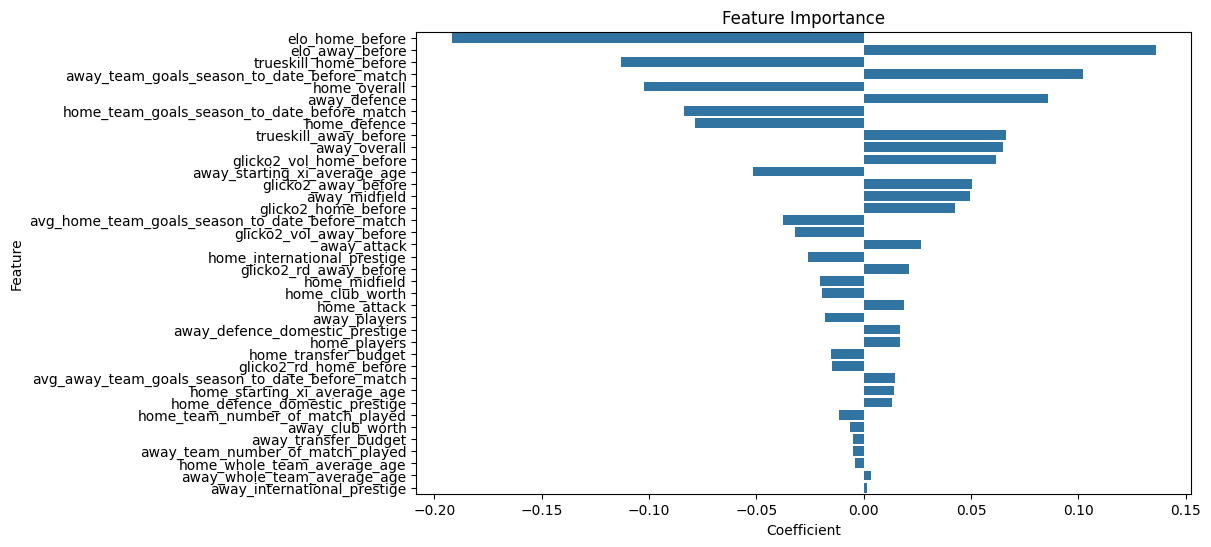

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Coefficient', y='Feature', ax=ax)
plt.title('Feature Importance')
plt.show()


In [263]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

X_col_sofifa =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

X_col_scores = ['elo_home_before',
       'elo_away_before', 'home_team_goals_season_to_date_before_match',
       'away_team_goals_season_to_date_before_match',
       'home_team_number_of_match_played', 'away_team_number_of_match_played',
       'avg_home_team_goals_season_to_date_before_match',
       'avg_away_team_goals_season_to_date_before_match',
       'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
       'glicko2_rd_away_before', 'glicko2_vol_home_before',
       'glicko2_vol_away_before', 'trueskill_home_before',
       'trueskill_away_before']

Y_col = 'FTR'

X_col = X_col_sofifa + X_col_scores

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.524226
1,weighted_accuracy,0.666929
2,accuracy_home,0.595446
3,accuracy_draw,0.740984
4,accuracy_away,0.712022
5,recall_all,1.337450
6,weighted_recall,0.524226
7,balanced_accuracy,0.445817
8,recall_home,0.839059
9,recall_draw,0.000000


In [264]:
matchs

,game_id,league,season,game,round,week,day,date,time,home_team,...,avg_home_team_goals_season_to_date_before_match,avg_away_team_goals_season_to_date_before_match,glicko2_home_before,glicko2_away_before,glicko2_rd_home_before,glicko2_rd_away_before,glicko2_vol_home_before,glicko2_vol_away_before,trueskill_home_before,trueskill_away_before
0,ffc11029,ESP-La Liga,0607,2006-09-09 Atlético Madrid-Valencia,None,2.0,Sat,2006-09-09,None,Atlético Madrid,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
2,60c88132,FRA-Ligue 1,0607,2006-09-09 Nantes-Lille,None,5.0,Sat,2006-09-09,None,Nantes,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
7,880e137f,ENG-Premier League,0607,2006-09-09 Everton-Liverpool,None,4.0,Sat,2006-09-09,None,Everton,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
8,4742f790,ENG-Premier League,0607,2006-09-09 Newcastle Utd-Fulham,None,4.0,Sat,2006-09-09,None,Newcastle Utd,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
15,36cd8447,ITA-Serie A,0607,2006-09-09 Fiorentina-Inter,None,1.0,Sat,2006-09-09,None,Fiorentina,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31695,65f327b4,ITA-Serie A,2324,2024-05-26 Frosinone-Udinese,None,38.0,Sun,2024-05-26,20:45:00,Frosinone,...,1.189189,0.972973,1429.576678,1478.806721,27.742751,28.358088,0.059869,0.059406,19.883196,21.762933
31696,723ffa45,GER-Bundesliga,2324,2024-05-27 Düsseldorf-Bochum,German 1/2 Relegation/Promotion Play-offs,NaN,Mon,2024-05-27,20:30:00,Düsseldorf,...,3.000000,1.200000,1467.347180,1445.023712,28.594862,28.662918,0.059902,0.059850,20.755207,20.932579
31697,febd4e01,FRA-Ligue 1,2324,2024-05-30 Saint-Étienne-Metz,French 1/2 Relegation/Promotion Play-off,NaN,Thu,2024-05-30,20:30:00,Saint-Étienne,...,0.000000,1.030303,1500.995626,1429.341828,28.911646,27.148533,0.059508,0.059741,22.420056,21.256931
31698,7f01f697,FRA-Ligue 1,2324,2024-06-02 Metz-Saint-Étienne,French 1/2 Relegation/Promotion Play-off,NaN,Sun,2024-06-02,17:00:00,Metz,...,1.029412,2.000000,1427.614394,1502.901106,27.491098,28.867743,0.059740,0.059507,21.179039,22.491376


In [261]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([
    ('model', GradientBoostingClassifier())
])
X_col_sofifa =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

X_col_scores = ['elo_home_before',
       'elo_away_before', 'home_team_goals_season_to_date_before_match',
       'away_team_goals_season_to_date_before_match',
       'home_team_number_of_match_played', 'away_team_number_of_match_played',
       'avg_home_team_goals_season_to_date_before_match',
       'avg_away_team_goals_season_to_date_before_match',
       'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
       'glicko2_rd_away_before', 'glicko2_vol_home_before',
       'glicko2_vol_away_before', 'trueskill_home_before',
       'trueskill_away_before']

Y_col = 'FTR'

X_col = X_col_sofifa + X_col_scores

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.508015
1,weighted_accuracy,0.658147
2,accuracy_home,0.595993
3,accuracy_draw,0.720765
4,accuracy_away,0.699271
5,recall_all,1.322781
6,weighted_recall,0.508015
7,balanced_accuracy,0.440927
8,recall_home,0.779394
9,recall_draw,0.048893


In [258]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

matchs = fbref_df_date_filtered_concat_no_nan

categorical_features = ['home_build_up_speed', 'home_build_up_dribbling', 'home_build_up_passing', 'home_build_up_positioning',
                        'home_chance_creation_crossing', 'home_chance_creation_passing', 'home_chance_creation_shooting', 
                        'home_chance_creation_positioning', 'home_defence_aggression', 'home_defence_pressure', 
                        'home_defence_team_width', 'home_defence_defender_line', 'home_fifa_edition', 'away_league',
                        'away_build_up_speed', 'away_build_up_dribbling', 'away_build_up_passing', 'away_build_up_positioning',
                        'away_chance_creation_crossing', 'away_chance_creation_passing', 'away_chance_creation_shooting', 
                        'away_chance_creation_positioning', 'away_defence_aggression', 'away_defence_pressure', 
                        'away_defence_team_width', 'away_defence_defender_line', 'away_fifa_edition']

numerical_features = ['home_overall', 'home_attack', 'home_midfield', 'home_defence', 'home_transfer_budget', 
                      'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 'home_players', 
                      'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 
                      'away_midfield', 'away_defence', 'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 
                      'away_international_prestige', 'away_players', 'away_starting_xi_average_age', 'away_whole_team_average_age',
                      
                        'elo_home_before',
                        'elo_away_before', 'home_team_goals_season_to_date_before_match',
                        'away_team_goals_season_to_date_before_match',
                        'home_team_number_of_match_played', 'away_team_number_of_match_played',
                        'avg_home_team_goals_season_to_date_before_match',
                        'avg_away_team_goals_season_to_date_before_match',
                        'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
                        'glicko2_rd_away_before', 'glicko2_vol_home_before',
                        'glicko2_vol_away_before', 'trueskill_home_before',
                        'trueskill_away_before']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

X_col =  numerical_features + categorical_features
Y_col = 'FTR'

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

,metrics,values
0,accuracy,0.516576
1,weighted_accuracy,0.664557
2,accuracy_home,0.610200
3,accuracy_draw,0.718397
4,accuracy_away,0.704554
5,recall_all,1.343884
6,weighted_recall,0.516576
7,balanced_accuracy,0.447961
8,recall_home,0.777670
9,recall_draw,0.064365


In [361]:
matchs = fbref_df_date_filtered_concat_no_nan
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

X_col_sofifa =  ['home_overall', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

Y_col = 'FTR'

X_col = X_col_sofifa 

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.526230
1,weighted_accuracy,0.669174
2,accuracy_home,0.600182
3,accuracy_draw,0.742259
4,accuracy_away,0.710018
5,recall_all,1.353474
6,weighted_recall,0.526230
7,balanced_accuracy,0.451158
8,recall_home,0.835290
9,recall_draw,0.000725


In [359]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])


X_col_scores = ['elo_home_before',
       'elo_away_before', 'home_team_goals_season_to_date_before_match',
       'away_team_goals_season_to_date_before_match',
       'home_team_number_of_match_played', 'away_team_number_of_match_played',
       'avg_home_team_goals_season_to_date_before_match',
       'avg_away_team_goals_season_to_date_before_match',
       'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
       'glicko2_rd_away_before', 'glicko2_vol_home_before',
       'glicko2_vol_away_before', 'trueskill_home_before',
       'trueskill_away_before']

Y_col = 'FTR'

X_col = X_col_scores

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.526412
1,weighted_accuracy,0.669588
2,accuracy_home,0.603461
3,accuracy_draw,0.740984
4,accuracy_away,0.708379
5,recall_all,1.356488
6,weighted_recall,0.526412
7,balanced_accuracy,0.452163
8,recall_home,0.822167
9,recall_draw,0.001311


In [269]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

X_col_scores = ['elo_home_before',
       'elo_away_before', 'home_team_goals_season_to_date_before_match',
       'away_team_goals_season_to_date_before_match',
       'home_team_number_of_match_played', 'away_team_number_of_match_played',
       'avg_home_team_goals_season_to_date_before_match',
       'avg_away_team_goals_season_to_date_before_match',
       'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
       'glicko2_rd_away_before', 'glicko2_vol_home_before',
       'glicko2_vol_away_before', 'trueskill_home_before',
       'trueskill_away_before']

X_col_sofifa =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

Y_col = 'FTR'

X_col = ['home_overall', 'away_overall']

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.525137
1,weighted_accuracy,0.666807
2,accuracy_home,0.589800
3,accuracy_draw,0.742259
4,accuracy_away,0.718215
5,recall_all,1.336400
6,weighted_recall,0.525137
7,balanced_accuracy,0.445467
8,recall_home,0.857027
9,recall_draw,0.000000


In [219]:
matchs["league"].unique()

array(['ESP-La Liga', 'FRA-Ligue 1', 'ENG-Premier League', 'ITA-Serie A',
       'GER-Bundesliga', 'INT-European Championships', 'INT-World Cup'],
      dtype=object)

In [221]:
matchs[matchs['league'] == 'INT-European Championships'].columns

Index(['game_id', 'league', 'season', 'game', 'round', 'week', 'day', 'date',
       'time', 'home_team', 'home_xg', 'score', 'away_xg', 'away_team',
       'attendance', 'venue', 'referee', 'match_report', 'notes', 'index',
       'away_g', 'home_g', 'away_sat', 'home_sat', 'home_league',
       'home_overall', 'home_attack', 'home_midfield', 'home_defence',
       'home_transfer_budget', 'home_club_worth', 'home_build_up_speed',
       'home_build_up_dribbling', 'home_build_up_passing',
       'home_build_up_positioning', 'home_chance_creation_crossing',
       'home_chance_creation_passing', 'home_chance_creation_shooting',
       'home_chance_creation_positioning', 'home_defence_aggression',
       'home_defence_pressure', 'home_defence_team_width',
       'home_defence_defender_line', 'home_defence_domestic_prestige',
       'home_international_prestige', 'home_players',
       'home_starting_xi_average_age', 'home_whole_team_average_age',
       'home_fifa_edition', 'home_update'

In [246]:
team = "Scotland"

rule_league = (matchs['league'] == 'INT-European Championships')
rule_team_home = (matchs['home_team'] == team)
rule_team_away = (matchs['away_team'] == team)
rule_is_group_stage = (matchs['round'] == "Group stage")
rule_season = (matchs['season'] == "2021")

rule_home = rule_league & rule_team_home & rule_is_group_stage
rule_away = rule_league & rule_team_away & rule_is_group_stage

(matchs[rule_home]['home_g'].mean() 
 + matchs[rule_away]['away_g'].mean())/2

0.25

In [245]:
list(set(matchs[rule_league]['home_team'].unique()).union(set(matchs[rule_league]['away_team'].unique())))

['Austria',
 'Spain',
 'Northern Ireland',
 'Rep. of Ireland',
 'Russia',
 'Switzerland',
 'Finland',
 'Iceland',
 'Romania',
 'Poland',
 'Belgium',
 'Greece',
 'Türkiye',
 'Ukraine',
 'Germany',
 'Italy',
 'Portugal',
 'England',
 'Croatia',
 'Denmark',
 'Netherlands',
 'France',
 'Czechia',
 'Wales',
 'Scotland',
 'Hungary',
 'Sweden']

In [240]:
matchs[rule_league]

,game_id,league,season,game,round,week,day,date,time,home_team,...,avg_home_team_goals_season_to_date_before_match,avg_away_team_goals_season_to_date_before_match,glicko2_home_before,glicko2_away_before,glicko2_rd_home_before,glicko2_rd_away_before,glicko2_vol_home_before,glicko2_vol_away_before,trueskill_home_before,trueskill_away_before
2893,6a5972c3,INT-European Championships,0809,2008-06-08 Germany-Poland,Group stage,1.0,Sun,2008-06-08,20:45:00,Germany,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
2894,d5574cb6,INT-European Championships,0809,2008-06-09 Romania-France,Group stage,1.0,Mon,2008-06-09,18:00:00,Romania,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
2895,e53203ac,INT-European Championships,0809,2008-06-09 Netherlands-Italy,Group stage,1.0,Mon,2008-06-09,20:45:00,Netherlands,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
2899,62873a71,INT-European Championships,0809,2008-06-11 Czechia-Portugal,Group stage,2.0,Wed,2008-06-11,18:00:00,Czechia,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
2901,04c62d77,INT-European Championships,0809,2008-06-12 Croatia-Germany,Group stage,2.0,Thu,2008-06-12,18:00:00,Croatia,...,0.000000,2.000000,1500.000000,1506.329462,350.000000,57.330401,0.060000,0.060000,0.000000,7.881405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26337,1a1e61fe,INT-European Championships,2021,2021-07-03 Czechia-Denmark,Quarter-finals,NaN,Sat,2021-07-03,20:00:00,Czechia,...,1.250000,2.250000,1491.524162,1487.397432,28.921014,28.591259,0.059994,0.059989,17.341572,19.356173
26338,8589d5c5,INT-European Championships,2021,2021-07-03 Ukraine-England,Quarter-finals,NaN,Sat,2021-07-03,21:00:00,Ukraine,...,1.333333,1.000000,1483.905464,1504.886293,32.666631,28.980804,0.059999,0.059982,8.457761,20.195942
26339,997fefb3,INT-European Championships,2021,2021-07-06 Italy-Spain,Semi-finals,NaN,Tue,2021-07-06,20:00:00,Italy,...,2.200000,1.750000,1519.112037,1527.491431,29.072882,29.045812,0.059978,0.059968,25.511818,23.624489
26340,3c9e014a,INT-European Championships,2021,2021-07-07 England-Denmark,Semi-finals,NaN,Wed,2021-07-07,20:00:00,England,...,1.600000,2.200000,1507.150041,1489.787235,29.003243,28.706212,0.059982,0.059990,20.423127,20.194935


In [223]:
matchs[matchs['league'] == 'INT-European Championships']['away_g'].mean()

1.208955223880597

In [291]:
from sklearn.feature_selection import SelectKBest, f_classif
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
    ('model', LogisticRegression())
])

X_col_scores = ['elo_home_before',
       'elo_away_before', 'home_team_goals_season_to_date_before_match',
       'away_team_goals_season_to_date_before_match',
       'home_team_number_of_match_played', 'away_team_number_of_match_played',
       'avg_home_team_goals_season_to_date_before_match',
       'avg_away_team_goals_season_to_date_before_match',
       'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
       'glicko2_rd_away_before', 'glicko2_vol_home_before',
       'glicko2_vol_away_before', 'trueskill_home_before',
       'trueskill_away_before']

X_col_sofifa =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

Y_col = 'FTR'

X_col = X_col_scores + X_col_sofifa

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.527322
1,weighted_accuracy,0.668492
2,accuracy_home,0.594353
3,accuracy_draw,0.742259
4,accuracy_away,0.718033
5,recall_all,1.341719
6,weighted_recall,0.527322
7,balanced_accuracy,0.447240
8,recall_home,0.853755
9,recall_draw,0.000000


In [292]:
from sklearn.feature_selection import RFE

# Exemple de pipeline avec RFE pour la sélection des caractéristiques
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', RFE(estimator=LogisticRegression(), n_features_to_select=10)),
    ('model', LogisticRegression())
])

X_col_scores = ['elo_home_before',
       'elo_away_before', 'home_team_goals_season_to_date_before_match',
       'away_team_goals_season_to_date_before_match',
       'home_team_number_of_match_played', 'away_team_number_of_match_played',
       'avg_home_team_goals_season_to_date_before_match',
       'avg_away_team_goals_season_to_date_before_match',
       'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
       'glicko2_rd_away_before', 'glicko2_vol_home_before',
       'glicko2_vol_away_before', 'trueskill_home_before',
       'trueskill_away_before']

X_col_sofifa =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

Y_col = 'FTR'

X_col = X_col_scores + X_col_sofifa

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})


,metrics,values
0,accuracy,0.524772
1,weighted_accuracy,0.665978
2,accuracy_home,0.587796
3,accuracy_draw,0.742259
4,accuracy_away,0.719490
5,recall_all,1.332004
6,weighted_recall,0.524772
7,balanced_accuracy,0.444001
8,recall_home,0.852515
9,recall_draw,0.000000


In [293]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Exemple de pipeline avec SelectFromModel pour la sélection des caractéristiques
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100))),
    ('model', LogisticRegression())
])


X_col_scores = ['elo_home_before',
       'elo_away_before', 'home_team_goals_season_to_date_before_match',
       'away_team_goals_season_to_date_before_match',
       'home_team_number_of_match_played', 'away_team_number_of_match_played',
       'avg_home_team_goals_season_to_date_before_match',
       'avg_away_team_goals_season_to_date_before_match',
       'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
       'glicko2_rd_away_before', 'glicko2_vol_home_before',
       'glicko2_vol_away_before', 'trueskill_home_before',
       'trueskill_away_before']

X_col_sofifa =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

Y_col = 'FTR'

X_col = X_col_scores + X_col_sofifa

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.526594
1,weighted_accuracy,0.669727
2,accuracy_home,0.604189
3,accuracy_draw,0.741894
4,accuracy_away,0.707104
5,recall_all,1.359271
6,weighted_recall,0.526594
7,balanced_accuracy,0.453090
8,recall_home,0.818778
9,recall_draw,0.003279


In [305]:
from sklearn.feature_selection import SelectKBest, f_classif

accuracy = []
log_loss = []
classwise_ece = []
for k in range(1, 40):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=k)),
        ('model', LogisticRegression())
    ])

    X_col_scores = ['elo_home_before',
        'elo_away_before', 'home_team_goals_season_to_date_before_match',
        'away_team_goals_season_to_date_before_match',
        'home_team_number_of_match_played', 'away_team_number_of_match_played',
        'avg_home_team_goals_season_to_date_before_match',
        'avg_away_team_goals_season_to_date_before_match',
        'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
        'glicko2_rd_away_before', 'glicko2_vol_home_before',
        'glicko2_vol_away_before', 'trueskill_home_before',
        'trueskill_away_before']

    X_col_sofifa =  ['home_overall', 'home_attack', 
            'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
            'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
            'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
            'away_starting_xi_average_age', 'away_whole_team_average_age']

    Y_col = 'FTR'

    X_col = X_col_scores + X_col_sofifa

    train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
    result_df_all_splits = False
    m = 10
    beta = 1

    metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
    accuracy.append(metrics_mean['accuracy'])
    log_loss.append(metrics_mean['log_loss'])
    classwise_ece.append(metrics_mean['classwise_ECE'])

print(f"accuracy max: {max(accuracy)} at k = {accuracy.index(max(accuracy)) + 1}")
print(f"log_loss min: {min(log_loss)} at k = {log_loss.index(min(log_loss)) + 1}")
print(f"classwise_ece min: {min(classwise_ece)} at k = {classwise_ece.index(min(classwise_ece)) + 1}")

c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=39 is greater than n_features=38. All the features will be returned.
  warnings.warn(
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=39 is greater than n_features=38. All the features will be returned.
  warnings.warn(
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=39 is greater than n_features=38. All the features will be returned.
  warnings.warn(
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=39 is greater than n_features=38. All the features will be returned.
  warnings.warn(
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\feature_selection\_univariate

accuracy max: 0.5291438979963571 at k = 17
log_loss min: 0.9795907015198306 at k = 9
classwise_ece min: 0.023749395151879286 at k = 1


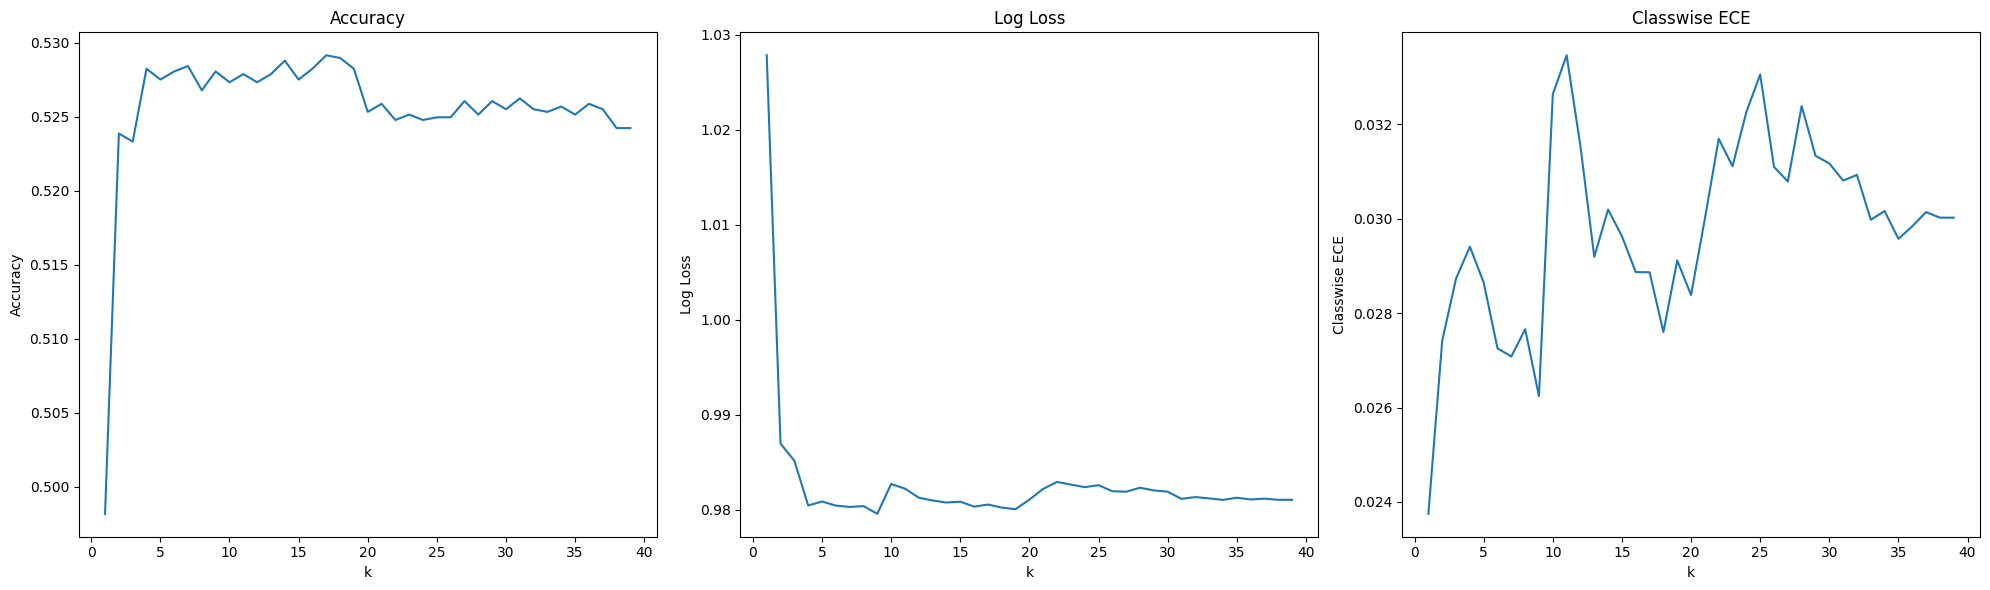

In [307]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].plot(range(1, 40), accuracy)
ax[0].set_title('Accuracy')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Accuracy')
ax[1].plot(range(1, 40), log_loss)
ax[1].set_title('Log Loss')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Log Loss')
ax[2].plot(range(1, 40), classwise_ece)
ax[2].set_title('Classwise ECE')
ax[2].set_xlabel('k')
ax[2].set_ylabel('Classwise ECE')
plt.tight_layout()
plt.show()


In [327]:
index = 16

print(f"accuracy at index {index}: {accuracy[index]}")
print(f"log_loss at index {index}: {log_loss[index]}")
print(f"classwise_ece at index {index}: {classwise_ece[index]}")

accuracy at index 16: 0.5291438979963571
log_loss at index 16: 0.9805649247853527
classwise_ece at index 16: 0.02886547215120842


In [301]:
np.max(accuracy)

0.5291438979963571

In [333]:
from sklearn.feature_selection import SelectKBest, f_classif
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=17)),
    ('model', LogisticRegression())
])

X_col_scores = ['elo_home_before',
       'elo_away_before', 'home_team_goals_season_to_date_before_match',
       'away_team_goals_season_to_date_before_match',
       'home_team_number_of_match_played', 'away_team_number_of_match_played',
       'avg_home_team_goals_season_to_date_before_match',
       'avg_away_team_goals_season_to_date_before_match',
       'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
       'glicko2_rd_away_before', 'glicko2_vol_home_before',
       'glicko2_vol_away_before', 'trueskill_home_before',
       'trueskill_away_before']

X_col_sofifa =  ['home_overall', 'home_attack', 
         'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
         'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
         'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
         'away_starting_xi_average_age', 'away_whole_team_average_age']

Y_col = 'FTR'

X_col = X_col_scores + X_col_sofifa

pipeline.fit(matchs[X_col], matchs[Y_col])

# Récupérer les noms des features après encodage
features_kept = pipeline.named_steps['feature_selection'].get_support()
feature_names = [X_col[i] for i in range(len(X_col)) if features_kept[i]]

feature_names

['avg_home_team_goals_season_to_date_before_match',
 'avg_away_team_goals_season_to_date_before_match',
 'glicko2_home_before',
 'glicko2_away_before',
 'glicko2_vol_away_before',
 'trueskill_home_before',
 'trueskill_away_before',
 'home_overall',
 'home_attack',
 'home_midfield',
 'home_defence',
 'home_defence_domestic_prestige',
 'home_international_prestige',
 'away_overall',
 'away_attack',
 'away_midfield',
 'away_defence']

In [337]:
train = fbref_df_date_filtered_concat_no_nan[~fbref_df_date_filtered_concat_no_nan["league"].isin(['INT-European Championships', 'INT-World Cup'])]
test = fbref_df_date_filtered_concat_no_nan[fbref_df_date_filtered_concat_no_nan["league"].isin(['INT-European Championships', 'INT-World Cup'])]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

X_col =  X_col_scores + X_col_sofifa

Y_col = 'FTR'

pipeline.fit(train[X_col], train[Y_col])
results = pipeline.predict(test[X_col])
test["results"] = results
accuracy = accuracy_fn(test, 'FTR', "results")
accuracy

C:\Users\jdelavande\AppData\Local\Temp\ipykernel_11556\2055367516.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["results"] = results


(0.5188679245283019,
 0.6667556663106681,
 (0.5786163522012578, 0.7578616352201258, 0.7012578616352201))

In [346]:
train = fbref_df_date_filtered_concat_no_nan[~fbref_df_date_filtered_concat_no_nan["league"].isin(['INT-European Championships', 'INT-World Cup'])]
test = fbref_df_date_filtered_concat_no_nan[fbref_df_date_filtered_concat_no_nan["league"].isin(['INT-European Championships', 'INT-World Cup'])]

accuracy = []
log_loss = []
classwise_ece = []
for k in range(1, 40):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=k)),
        ('model', LogisticRegression())
    ])
    X_col =  X_col_scores + X_col_sofifa

    Y_col = 'FTR'

    pipeline.fit(train[X_col], train[Y_col])
    results = pipeline.predict(test[X_col])
    results_proba = pipeline.predict_proba(test[X_col])
    test["results"] = results
    test["home_prob"] = results_proba[:, 2]
    test["draw_prob"] = results_proba[:, 1]
    test["away_prob"] = results_proba[:, 0]
    accuracy.append(accuracy_fn(test, 'FTR', "results")[0])
    log_loss.append(log_loss_fn(test['FTR'], test['home_prob'], test['draw_prob'], test['away_prob']))

print(f"accuracy max: {max(accuracy)} at k = {accuracy.index(max(accuracy)) + 1}")
print(f"log_loss min: {min(log_loss)} at k = {log_loss.index(min(log_loss)) + 1}")

C:\Users\jdelavande\AppData\Local\Temp\ipykernel_11556\2103926716.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["results"] = results
C:\Users\jdelavande\AppData\Local\Temp\ipykernel_11556\2103926716.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["home_prob"] = results_proba[:, 2]
C:\Users\jdelavande\AppData\Local\Temp\ipykernel_11556\2103926716.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

accuracy max: 0.5345911949685535 at k = 35
log_loss min: 1.0273806331961548 at k = 35


C:\Users\jdelavande\AppData\Local\Temp\ipykernel_11556\2103926716.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["results"] = results
C:\Users\jdelavande\AppData\Local\Temp\ipykernel_11556\2103926716.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["home_prob"] = results_proba[:, 2]
C:\Users\jdelavande\AppData\Local\Temp\ipykernel_11556\2103926716.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

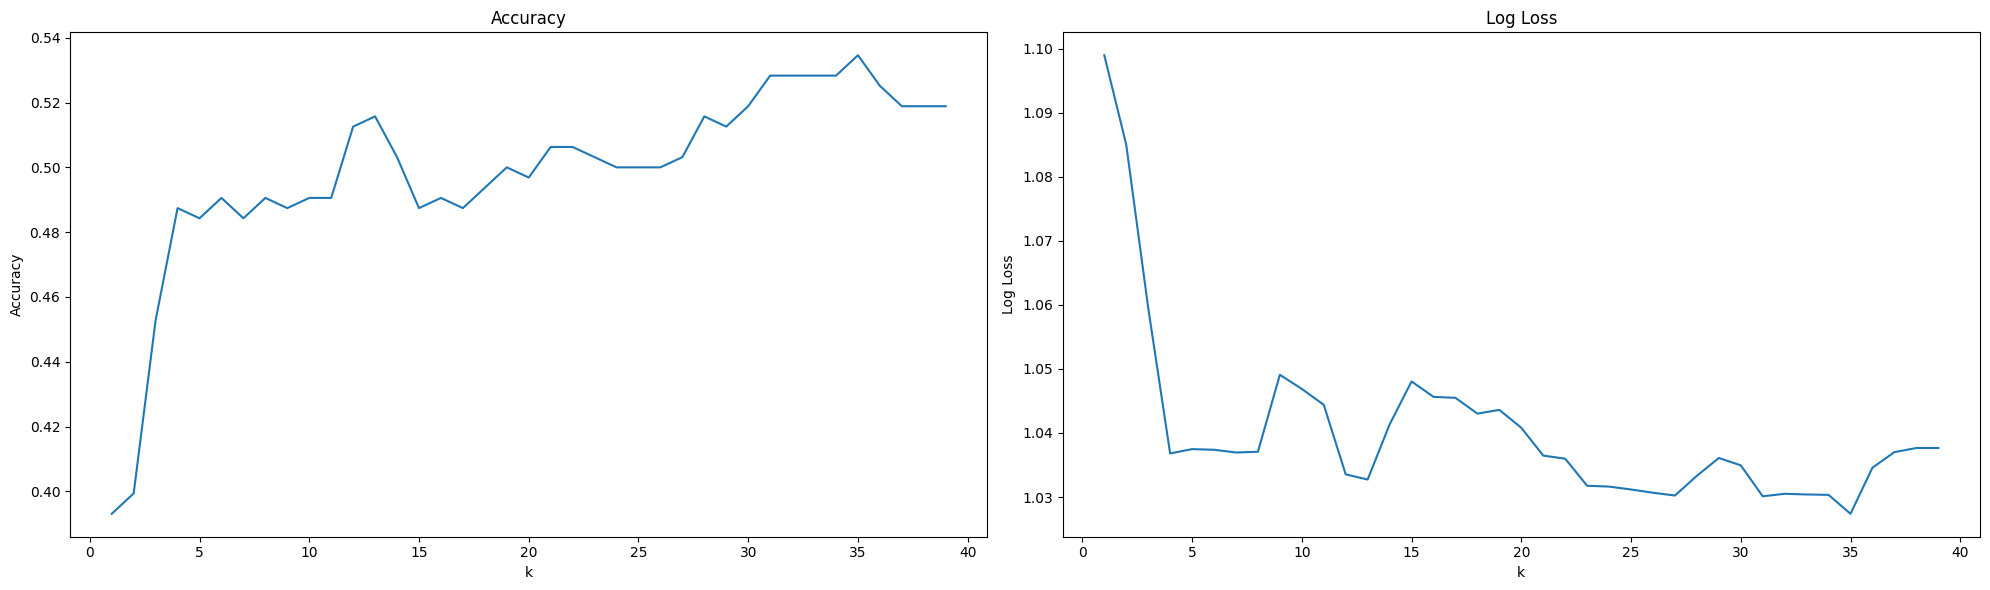

In [349]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].plot(range(1, 40), accuracy)
ax[0].set_title('Accuracy')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Accuracy')
ax[1].plot(range(1, 40), log_loss)
ax[1].set_title('Log Loss')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Log Loss')

plt.tight_layout()
plt.show()


In [350]:
print(f"accuracy max: {max(accuracy)} at k = {accuracy.index(max(accuracy)) + 1}")
print(f"log_loss min: {min(log_loss)} at k = {log_loss.index(min(log_loss)) + 1}")

accuracy max: 0.5345911949685535 at k = 35
log_loss min: 1.0273806331961548 at k = 35


In [351]:
len(X_col)

38